In [ ]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig()



In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!mkdir -p /drive

#umount /drive
!mount --bind /content/drive/My\ Drive /drive


Mounted at /content/drive


In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/패스트캠퍼스강의/실습자료/ch1")


In [ ]:
import argparse
import logging
import random
import time
import importlib

import torch
import torch.backends.cudnn as cudnn
from torch import optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence


from tqdm import tqdm

from utils.batches import batches, data_from_batch
from utils.embeddings import create_embedding_maps
from utils.masked_cross_entropy import masked_cross_entropy
from utils.tokens import Tokens

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:

import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

In [ ]:
batch_size = 50
hidden_size = 500
input_size = 500
different_vocab = True
learning_rate = 0.0001
eval_every = 50
eval_batch_size = 10 
n_layers = 2 
n_epochs = 10 
dropout = 0.1 
score_function = "general"
teacher_forcing_ratio = 1
decoder_learning_ratio = 5.
clip_norm = 5.0
rnn_cell = "GRU"
use_cuda = True
use_batch_attention = True

In [ ]:


class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, input_size, n_layers, dropout, word_embedding_matrix, rnn_cell, use_cuda):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.embedding = word_embedding_matrix
        self.use_cuda = use_cuda

        if rnn_cell == "GRU":
            self.rnn = nn.GRU(input_size, hidden_size, n_layers, dropout=dropout, bidirectional=True)

    def forward(self, input_seqs, hidden, input_lengths):
        """
        input_seqs : (Max input length, batch_size)
        input_lengths: (batch_size)
        """

        # Max input length, batch size, hidden_size
        embedded = self.embedding(input_seqs)
        packed = pack_padded_sequence(embedded, input_lengths)
        outputs, hidden = self.rnn(packed, hidden)
        outputs, output_lengths = pad_packed_sequence(outputs)

        # Max input length, batch_size, hidden_size, we add the backward and forward
        # hidden states together
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, :, self.hidden_size:]

        # Get the forwards and backwards hidden states
        hidden_layers = []
        for i in range(self.n_layers):
            hidden_layers.append((hidden[i * 2, :, :] + hidden[(i * 2) + 1, :, :]).unsqueeze(0))
        return outputs, torch.cat(hidden_layers, 0)

    def init_hidden(self, batch_size):
        hidden = Variable(torch.zeros(self.n_layers * 2, batch_size, self.hidden_size))
        if self.use_cuda: hidden = hidden.cuda()
        return hidden

class Attn(nn.Module):
    def __init__(self, method, hidden_size, use_cuda=False):
        super().__init__()
        self.method = method
        self.hidden_size = hidden_size
        self.use_cuda = use_cuda

        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        """
        hidden : 1, batch_size, hidden_size
        encoder_outputs : max input length, batch_size, hidden_size
        """
        # max_len = encoder_outputs.size(0)
        # this_batch_size = encoder_outputs.size(1)

        attn_energies = torch.bmm(self.attn(hidden).transpose(1, 0), encoder_outputs.permute(1, 2, 0))

        # Batch size, 1, max input length
        return F.softmax(attn_energies)

    def score(self, hidden, encoder_output):

        if self.method == 'general':
            energy = self.attn(encoder_output).view(-1)
            energy = hidden.view(-1).dot(energy)
            return energy



class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, score_function, hidden_size, input_size, output_size,
                 n_layers, dropout , word_embedding_matrix, use_cuda):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.score_function = score_function
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.use_cuda = use_cuda

        # Define layers
        self.embedding = word_embedding_matrix
        self.gru = nn.GRU(self.input_size, self.hidden_size, n_layers, dropout=self.dropout)
        self.concat = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

        # Choose attention models
        if score_function != 'none':
            self.attn = Attn(score_function, hidden_size, use_cuda=use_cuda)

    def forward(self, input_seq, last_hidden, encoder_outputs):
        """
        input_seq : batch_size
        hidden : hidden_size, batch_size
        encoder_outputs : max input length, batch_size, hidden_size
        """
        # Note: we run this one step at a time

        # logging.debug(f"input_seq:\n{input_seq}")
        # logging.debug(f"last_hidden:\n{last_hidden}")
        # logging.debug(f"encoder_outputs:\n{encoder_outputs}")

        batch_size = input_seq.size(0)

        # (batch size, hidden_size)
        embedded = self.embedding(input_seq)

        # (1, batch size, input_size) add another dimension so that it works with
        # the GRU
        embedded = embedded.view(1, batch_size, self.input_size)  # S=1 x B x N

        logging.debug(f"embedded:\n{embedded}")
        # Get current hidden state from input word and last hidden state
        rnn_output, hidden = self.gru(embedded, last_hidden)
        logging.debug(f"rnn_output:\n{rnn_output}")
        logging.debug(f"hidden:\n{hidden}")


        # Calculate attention from current RNN state and all encoder outputs;
        # apply to encoder outputs to get weighted average

        # batch size, max input length
        attn_weights = self.attn(rnn_output, encoder_outputs)
        logging.debug(f"attn_weights:\n{attn_weights}")

        # (batch_size, 1, max input length) @ batch_size, max input length, hidden size
        # note that we use this convention here to take advantage of the bmm function
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))  # B x S=1 x N

        # Attentional vector using the RNN hidden state and context vector
        # concatenated together (Luong eq. 5)
        rnn_output = rnn_output.squeeze(0)  # S=1 x B x N -> B x N
        context = context.squeeze(1)  # B x S=1 x N -> B x N
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = F.tanh(self.concat(concat_input))

        # Finally predict next token (Luong eq. 6, without fftmax)
        output = self.out(concat_output)

        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights


In [ ]:


def run_train(n_epochs,
              batch_size,
              eval_batch_size,
              eval_every,
              train,
              val,
              encoder_embedding_map,
              decoder_embedding_map,
              encoder,
              decoder,
              encoder_optimizer,
              decoder_optimizer,
              clip_norm,
              teacher_forcing_ratio,
              use_cuda,
              ):
    for i in range(n_epochs):
        logging.info(f"EPOCH: {i+1}")
        for j, batch in enumerate(tqdm(batches(train,
                                               encoder_embedding_map,
                                               decoder_embedding_map,
                                               use_cuda=use_cuda,
                                               batch_size=batch_size))):
            encoder.train()
            decoder.train()
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()

            source_var, source_lengths, target_var, target_lengths = data_from_batch(batch)

            current_batch_size = len(target_lengths)

            # encoder_outputs: max input length, batch size, hidden size
            # encoder_hidden: num_layers, batch size, hidden size
            logging.debug("Encoding")
            tic = time.time()
            encoder_outputs, encoder_hidden = encoder(source_var,
                                                      encoder.init_hidden(current_batch_size),
                                                      source_lengths)
            toc = time.time()
            logging.debug(f"Seconds take to encode: {round(toc-tic,2)}")
            decoder_input = Variable(torch.LongTensor([Tokens.SOS_token] * current_batch_size))
            decoder_hidden = encoder_hidden
            if use_cuda:
                decoder_input = decoder_input.cuda()
                decoder_hidden = decoder_hidden.cuda()

            logging.debug("Decoding")
            tic = time.time()

            max_target_length = max(target_lengths)
            all_decoder_outputs = Variable(torch.zeros(max_target_length, current_batch_size, decoder.output_size))




            if use_cuda:
                all_decoder_outputs = all_decoder_outputs.cuda()

            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

            if use_teacher_forcing:
                logging.debug("Using teacher forcing")
                for t in range(max_target_length):
                    decoder_output, decoder_hidden, att = decoder(decoder_input,
                                                                decoder_hidden,
                                                                encoder_outputs)
                    all_decoder_outputs[t] = decoder_output


                    decoder_input = target_var[t]
            else:
                ## TODO: how do I do non-teacher forcing for batch inputs?
                logging.debug("Not using teacher forcing")
                for t in range(max_target_length):
                    decoder_output, decoder_hidden, _ = decoder(decoder_input,
                                                                decoder_hidden,
                                                                encoder_outputs)
                    all_decoder_outputs[t] = decoder_output
                    _, top_i = decoder_output.data.topk(1)
                    decoder_input = Variable(top_i).squeeze(1)

            toc = time.time()
            loss = masked_cross_entropy(all_decoder_outputs.transpose(0, 1).contiguous(),
                                        target_var.transpose(0, 1).contiguous(),
                                        target_lengths,
                                        use_cuda=use_cuda)
            logging.debug(f"Time taken for 1 decode step: {round(toc-tic, 2)}")
            logging.debug("Backpropagating")

            tic = time.time()
            loss.backward()
            toc = time.time()
            logging.debug(f"Seconds taken for backpropagation: {round(toc-tic, 2)}")

            # Clip gradients
            logging.debug("Clipping Gradients")
            _ = torch.nn.utils.clip_grad_norm(encoder.parameters(), clip_norm)
            _ = torch.nn.utils.clip_grad_norm(decoder.parameters(), clip_norm)

            logging.debug("Updating Weights")
            encoder_optimizer.step()
            decoder_optimizer.step()

            if j % eval_every == 0:
                run_eval(encoder_embedding_map,
                         decoder_embedding_map,
                         encoder,
                         decoder,
                         val,
                         eval_batch_size,
                         use_cuda=use_cuda)

                run_eval(encoder_embedding_map,
                         decoder_embedding_map,
                         encoder,
                         decoder,
                         train,
                         batch_size,
                         use_cuda=use_cuda)

            logging.info(f"LOSS: {loss.data}")


def run_eval(encoder_embedding_map,
             decoder_embedding_map,
             encoder,
             decoder,
             val,
             batch_size,
             use_cuda=False):

    batch = next(batches(val,
                 encoder_embedding_map,
                 decoder_embedding_map,
                 bucket=False,
                 batch_size=batch_size,
                 use_cuda=use_cuda))

    # Disable to avoid dropout
    encoder.eval()
    decoder.eval()

    source_var, source_lengths, target_var, target_lengths = data_from_batch(batch)
    
    current_batch_size = len(target_lengths)

    encoder_outputs, encoder_hidden = encoder(source_var,
                                              encoder.init_hidden(current_batch_size),
                                              source_lengths)

    # (1, eval_batch_size)
    decoder_inputs = Variable(torch.LongTensor([Tokens.SOS_token] * current_batch_size))
    decoder_hidden = encoder_hidden
    max_target_length = max(target_lengths)
    all_decoder_outputs = Variable(torch.zeros(max_target_length, current_batch_size, decoder.output_size))

    if use_cuda:
        decoder_inputs = decoder_inputs.cuda()
        all_decoder_outputs = all_decoder_outputs.cuda()

    # decoder_attentions = torch.zeros(eval_batch_size, max_target_length, max_target_length)
    decoder_attentions = torch.zeros(max_target_length, max_target_length)

    logging.info("Decoding")

    for t in tqdm(range(max_target_length)):
        decoder_output, decoder_hidden, attn_weights = decoder(decoder_inputs,
                                                               decoder_hidden,
                                                               encoder_outputs)
        decoder_attentions[t] = attn_weights[0].detach() # (max_leng)

        # num_time_step (will be 1), batch_size, output_vocab_size
        all_decoder_outputs[t] = decoder_output

        # num_time_step (will be 1), batch_size, 1
        _, top_i = decoder_output.data.topk(1)
        decoder_inputs = Variable(top_i).squeeze(1)
        # colorbar로 그림 설정
    print(attn_weights.shape)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(decoder_attentions.detach().to("cpu").numpy(), cmap='bone')
    fig.colorbar(cax)

    format_eval_output(encoder_embedding_map,
                       decoder_embedding_map,
                       source_var,
                       target_var,
                       all_decoder_outputs)


def format_eval_output(encoder_embedding_map,
                       decoder_embedding_map,
                       inp,
                       target,
                       all_decoder_outputs):
    inp = inp.cpu()
    target = target.cpu()
    _, batch_top_i = all_decoder_outputs.topk(1)
    batch_top_i = batch_top_i.cpu().squeeze(-1).transpose(1, 0).data.numpy()

    input_sentences = []
    target_sentences = []
    decoded_sentences = []

    for var in inp.transpose(1, 0).data.numpy():
        input_sentences.append(encoder_embedding_map.get_sentence_from_indexes(var))
    for var in target.transpose(1, 0).data.numpy():
        target_sentences.append(decoder_embedding_map.get_sentence_from_indexes(var))
    for indexes in batch_top_i:
        sentence = decoder_embedding_map.get_sentence_from_indexes(indexes)
        trunc_sentence = []
        for word in sentence:
            if word != "<EOS>":
                trunc_sentence.append(word)
            else:
                break
        decoded_sentences.append(trunc_sentence)

    for source, target, decode in zip(input_sentences, target_sentences, decoded_sentences):
        logging.info(f"\nSource:{' '.join(source)}\nTarget:{' '.join(target)}\nDecode:{' '.join(decode)}")
    


In [ ]:
def load_data(dataset_module, train_dir, debug_restrict_data):
    dataset_module_path = f"utils.load_and_preprocessing.{dataset_module}"
    dataset_module = importlib.import_module(dataset_module_path)
    train, val = dataset_module.load_data(train_dir, debug_restrict_data)
    return train, val
train, val = load_data("translation", "/content/drive/MyDrive/패스트캠퍼스강의/실습자료/ch1/data/translation", None)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
100%|██████████| 10/10 [00:00<00:00, 5548.02it/s]


In [ ]:
val

,source,target
0,je vais vous conter un secret .,i m going to tell you a secret .
1,elles sont russes .,they are russian .
2,il est photogenique .,he is photogenic .
3,on est dans les clous .,we re on schedule .
4,c est un auteur .,he s an author .
5,vous etes trop confiante .,you re too trusting .
6,je suis en train de changer de poste .,i m between jobs .
7,elle plante des roses dans le jardin .,she s in the garden planting roses .
8,vous etes tres elegante .,you re very stylish .
9,nous sommes bourrees .,we re sloshed .


In [ ]:
logging.info("Creating embedding maps")
encoder_embedding_map, \
decoder_embedding_map, \
encoder_embedding_matrix, \
decoder_embedding_matrix = create_embedding_maps(train, val, input_size, different_vocab)

INFO:root:Creating embedding maps
100%|██████████| 10835/10835 [00:00<00:00, 149326.51it/s]

100%|██████████| 10835/10835 [00:00<00:00, 161918.29it/s]

100%|██████████| 2/2 [00:00<00:00, 16.62it/s]


In [ ]:
encoder = EncoderRNN(hidden_size,
                          input_size,
                          n_layers,
                          dropout,
                          encoder_embedding_matrix,
                          rnn_cell,
                          use_cuda)

decoder = LuongAttnDecoderRNN(score_function,
                            hidden_size,
                            input_size,
                            decoder_embedding_map.n_words,
                            n_layers,
                            dropout,
                            decoder_embedding_matrix,
                            use_cuda)


In [ ]:
encoder

EncoderRNN(
  (embedding): Embedding(4490, 500)
  (rnn): GRU(500, 500, num_layers=2, dropout=0.1, bidirectional=True)
)

In [ ]:
decoder

LuongAttnDecoderRNN(
  (embedding): Embedding(2927, 500)
  (gru): GRU(500, 500, num_layers=2, dropout=0.1)
  (concat): Linear(in_features=1000, out_features=500, bias=True)
  (out): Linear(in_features=500, out_features=2927, bias=True)
  (attn): Attn(
    (attn): Linear(in_features=500, out_features=500, bias=True)
  )
)

INFO:root:Starting training
INFO:root:EPOCH: 1
0it [00:00, ?it/s]<ipython-input-7-a15f1f01e15d>:65: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(attn_energies)
<ipython-input-27-e24957fedee2>:98: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  _ = torch.nn.utils.clip_grad_norm(encoder.parameters(), clip_norm)
<ipython-input-27-e24957fedee2>:99: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  _ = torch.nn.utils.clip_grad_norm(decoder.parameters(), clip_norm)
INFO:root:Decoding

100%|██████████| 10/10 [00:00<00:00, 113.85it/s]
INFO:root:
Source:je suis en train de changer de poste . <EOS>
Target:i m between jobs . <EOS> <PAD> <PAD> <PAD> <PAD>
Decode:i m from england .
INFO:root:
Source:elle plante des roses dans le jardin . <EOS> <PAD>
Target:she s in the garden planting roses 

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 75.60it/s]
INFO:root:
Source:je ne suis pas la pour me battre . <EOS>
Target:i m not here to fight . <EOS> <PAD> <PAD>
Decode:i m not your friend .
INFO:root:
Source:je suis heureuse que tu l aies apprecie . <EOS>
Target:i m glad you liked it . <EOS> <PAD> <PAD>
Decode:i m glad you re here .
INFO:root:
Source:tu restes avec tom n est ce pas ? <EOS>
Target:you re staying with tom right ? <EOS> <PAD> <PAD>
Decode:you re new here aren t you ?
INFO:root:
Source:il est en train de lire un roman . <EOS>
Target:he s reading a novel right now . <EOS> <PAD>
Decode:he is a little bit tired .
INFO:root:
Source:il n est pas apte a etre enseignant . <EOS>
Target:he is unfit to be a teacher . <EOS> <PAD>
Decode:he is not a doctor to the result .
INFO:root:
Source:je te le demande en tant qu ami . <EOS>
Target:i m asking you as a friend . <EOS> <PAD>
Decode:i m glad you re all happy .
INFO:root:
Source:je suis ravi que vous ayez pu venir . <EOS>
Target:i m glad y

torch.Size([50, 1, 10])


INFO:root:LOSS: 1.794150710105896
2it [00:00,  2.40it/s]INFO:root:LOSS: 1.2881338596343994
3it [00:01,  3.29it/s]INFO:root:LOSS: 1.5032297372817993
4it [00:01,  3.94it/s]INFO:root:LOSS: 1.7671282291412354
5it [00:01,  4.53it/s]INFO:root:LOSS: 1.5518571138381958
6it [00:01,  4.95it/s]INFO:root:LOSS: 1.5442655086517334
7it [00:01,  5.25it/s]INFO:root:LOSS: 1.5410237312316895
8it [00:01,  5.42it/s]INFO:root:LOSS: 1.4644434452056885
9it [00:02,  5.56it/s]INFO:root:LOSS: 1.4768961668014526
10it [00:02,  5.66it/s]INFO:root:LOSS: 1.550896406173706
11it [00:02,  5.74it/s]INFO:root:LOSS: 1.562355637550354
12it [00:02,  5.73it/s]INFO:root:LOSS: 1.8581407070159912
13it [00:02,  5.78it/s]INFO:root:LOSS: 1.6983553171157837
14it [00:02,  5.84it/s]INFO:root:LOSS: 1.714818000793457
15it [00:03,  5.89it/s]INFO:root:LOSS: 1.6087932586669922
16it [00:03,  5.66it/s]INFO:root:LOSS: 1.3871632814407349
17it [00:03,  5.83it/s]INFO:root:LOSS: 1.4208863973617554
18it [00:03,  5.87it/s]INFO:root:LOSS: 1.74778687

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 56.93it/s]
INFO:root:
Source:il est trop jeune pour y aller seul . <EOS>
Target:he is too young to go there alone . <EOS>
Decode:he s too too old for me .
INFO:root:
Source:vous n etes pas aussi petit que moi . <EOS>
Target:you aren t as short as i am . <EOS>
Decode:you aren t as smart as me .
INFO:root:
Source:il n est plus aussi fort qu avant . <EOS>
Target:he is not strong as before . <EOS> <PAD> <PAD>
Decode:he is not as smart as me .
INFO:root:
Source:je suis desole de vous avoir hurle dessus . <EOS>
Target:i m sorry i yelled at you . <EOS> <PAD>
Decode:i m sorry to have bothered you .
INFO:root:
Source:je suis desolee . j ai oublie . <EOS> <PAD>
Target:i m sorry . i forgot . <EOS> <PAD> <PAD>
Decode:i m sorry .
INFO:root:
Source:je vais en europe la semaine prochaine . <EOS> <PAD>
Target:i am going to europe next week . <EOS> <PAD>
Decode:i m going to be a doctor .
INFO:root:
Source:elle a une peur bleue des chiens . <EOS> <PAD>
Target:she s 

torch.Size([50, 1, 10])


INFO:root:LOSS: 1.7222212553024292
52it [00:10,  2.70it/s]INFO:root:LOSS: 1.5441803932189941
53it [00:10,  3.09it/s]INFO:root:LOSS: 1.702142596244812
54it [00:10,  3.45it/s]INFO:root:LOSS: 1.7507739067077637
55it [00:11,  3.74it/s]INFO:root:LOSS: 1.6751705408096313
56it [00:11,  3.99it/s]INFO:root:LOSS: 1.8673774003982544
57it [00:11,  4.15it/s]INFO:root:LOSS: 1.6909399032592773
58it [00:11,  4.44it/s]INFO:root:LOSS: 1.4370381832122803
59it [00:11,  4.83it/s]INFO:root:LOSS: 1.45207679271698
60it [00:12,  5.10it/s]INFO:root:LOSS: 1.5548020601272583
61it [00:12,  5.34it/s]INFO:root:LOSS: 1.7685588598251343
62it [00:12,  5.55it/s]INFO:root:LOSS: 1.7755775451660156
63it [00:12,  5.66it/s]INFO:root:LOSS: 1.5167577266693115
64it [00:12,  5.78it/s]INFO:root:LOSS: 1.8384150266647339
65it [00:12,  5.87it/s]INFO:root:LOSS: 1.6775932312011719
66it [00:12,  5.94it/s]INFO:root:LOSS: 1.5114439725875854
67it [00:13,  5.95it/s]INFO:root:LOSS: 1.786668300628662
68it [00:13,  6.05it/s]INFO:root:LOSS: 1.

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 74.77it/s]
INFO:root:
Source:elle est en train de coucher les enfants . <EOS>
Target:she s putting the children to bed . <EOS> <PAD>
Decode:she is in the mood of the result .
INFO:root:
Source:je suis desolee si je vous ai derangees . <EOS>
Target:i m sorry if i disturbed you . <EOS> <PAD>
Decode:i m sorry if i frightened you .
INFO:root:
Source:il est en train d ecrire un roman . <EOS>
Target:he is writing a novel . <EOS> <PAD> <PAD> <PAD>
Decode:he is a gentleman .
INFO:root:
Source:vous etes deux fois plus fortes que moi . <EOS>
Target:you are twice as strong as i am . <EOS>
Decode:you re smarter than me .
INFO:root:
Source:il est en colere apres tout le monde . <EOS>
Target:he s mad at everyone . <EOS> <PAD> <PAD> <PAD>
Decode:he is in the same age .
INFO:root:
Source:tu as le meme age que mon fils . <EOS>
Target:you re the same age as my son . <EOS>
Decode:you re the one who trained me .
INFO:root:
Source:je me rejouis de vous avoir finalement

torch.Size([50, 1, 10])


INFO:root:LOSS: 1.7163394689559937
102it [00:19,  3.53it/s]INFO:root:LOSS: 1.4342728853225708
103it [00:19,  3.98it/s]INFO:root:LOSS: 1.627448558807373
104it [00:19,  4.44it/s]INFO:root:LOSS: 1.5521769523620605
105it [00:19,  4.84it/s]INFO:root:LOSS: 1.561543583869934
106it [00:20,  5.23it/s]INFO:root:LOSS: 1.5625965595245361
107it [00:20,  5.40it/s]INFO:root:LOSS: 1.508968472480774
108it [00:20,  5.58it/s]INFO:root:LOSS: 1.619600772857666
109it [00:20,  5.67it/s]INFO:root:LOSS: 1.8077977895736694
110it [00:20,  5.83it/s]INFO:root:LOSS: 1.6239017248153687
111it [00:20,  5.89it/s]INFO:root:LOSS: 1.6678171157836914
112it [00:21,  5.99it/s]INFO:root:LOSS: 1.6273361444473267
113it [00:21,  5.98it/s]INFO:root:LOSS: 1.4615520238876343
114it [00:21,  5.91it/s]INFO:root:LOSS: 1.4285868406295776
115it [00:21,  6.07it/s]INFO:root:LOSS: 1.657900333404541
116it [00:21,  5.42it/s]INFO:root:LOSS: 1.5906797647476196
117it [00:22,  5.10it/s]INFO:root:LOSS: 1.7435283660888672
118it [00:22,  4.92it/s]IN

torch.Size([10, 1, 10])


INFO:root:Decoding

100%|██████████| 10/10 [00:00<00:00, 71.71it/s]
INFO:root:
Source:je me rejouis de t avoir finalement rencontre . <EOS>
Target:i m glad to finally meet you . <EOS> <PAD>
Decode:i m glad i invited you .
INFO:root:
Source:je suis tres content de ma nouvelle voiture . <EOS>
Target:i am really pleased with my new car . <EOS>
Decode:i m very glad to have a lot of money
INFO:root:
Source:je suis desole je ne gobe pas ca . <EOS>
Target:i m sorry i don t buy it . <EOS>
Decode:i m sorry i don t recognize you .
INFO:root:
Source:je ne suis pas aussi maligne que toi . <EOS>
Target:i m not as smart as you . <EOS> <PAD>
Decode:i m not as smart as you .
INFO:root:
Source:je n en ai pas fini avec vous . <EOS>
Target:i m not finished with you . <EOS> <PAD> <PAD>
Decode:i m not afraid of you .
INFO:root:
Source:vous n etes pas aussi malin que moi . <EOS>
Target:you re not as smart as me . <EOS> <PAD>
Decode:you re not as smart as me .
INFO:root:
Source:je suis content que tu sois to

torch.Size([50, 1, 10])


INFO:root:LOSS: 1.5205920934677124
152it [00:29,  3.17it/s]INFO:root:LOSS: 1.5881131887435913
153it [00:29,  3.67it/s]INFO:root:LOSS: 1.6063024997711182
154it [00:29,  4.15it/s]INFO:root:LOSS: 1.6498662233352661
155it [00:29,  4.70it/s]INFO:root:LOSS: 1.4198013544082642
156it [00:29,  4.96it/s]INFO:root:LOSS: 1.5303541421890259
157it [00:30,  5.26it/s]INFO:root:LOSS: 1.5197635889053345
158it [00:30,  5.40it/s]INFO:root:LOSS: 1.4831277132034302
159it [00:30,  5.56it/s]INFO:root:LOSS: 1.8545912504196167
160it [00:30,  5.68it/s]INFO:root:LOSS: 1.8097814321517944
161it [00:30,  5.77it/s]INFO:root:LOSS: 1.7462176084518433
162it [00:30,  5.78it/s]INFO:root:LOSS: 1.7120246887207031
163it [00:31,  5.86it/s]INFO:root:LOSS: 1.6426012516021729
164it [00:31,  5.84it/s]INFO:root:LOSS: 1.3667272329330444
165it [00:31,  5.82it/s]INFO:root:LOSS: 1.571734070777893
166it [00:31,  5.89it/s]INFO:root:LOSS: 1.6196284294128418
167it [00:31,  5.94it/s]INFO:root:LOSS: 1.5027968883514404
168it [00:31,  6.00it/

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 71.45it/s]
INFO:root:
Source:elle fait un regime pour perdre du poids . <EOS>
Target:she is on a diet to lose weight . <EOS>
Decode:she is wearing a little ring .
INFO:root:
Source:tu es blanc comme un cachet d aspirine . <EOS>
Target:you are as white as a sheet . <EOS> <PAD>
Decode:you re a funny girl .
INFO:root:
Source:je fais attention a ne pas trop depenser . <EOS>
Target:i m careful not to spend too much . <EOS>
Decode:i m not worried about you .
INFO:root:
Source:il est en train de lire un livre . <EOS>
Target:he is reading a book . <EOS> <PAD> <PAD> <PAD>
Decode:he is a bit of a doctor .
INFO:root:
Source:nous sommes sur le chemin de la maison . <EOS>
Target:we are on the way home . <EOS> <PAD> <PAD>
Decode:we are the same age .
INFO:root:
Source:je vais aller rejoindre les bras de morphee . <EOS>
Target:i am going to sleep . <EOS> <PAD> <PAD> <PAD>
Decode:i m going to need the police .
INFO:root:
Source:vous faites tout ce que vous pouvez 

torch.Size([50, 1, 10])


INFO:root:LOSS: 1.6140815019607544
202it [00:38,  2.92it/s]INFO:root:LOSS: 1.4441752433776855
203it [00:39,  3.46it/s]INFO:root:LOSS: 1.4182062149047852
204it [00:39,  3.97it/s]INFO:root:LOSS: 1.6197179555892944
205it [00:39,  4.44it/s]INFO:root:LOSS: 1.481194257736206
206it [00:39,  4.82it/s]INFO:root:LOSS: 1.5883270502090454
207it [00:39,  5.16it/s]INFO:root:LOSS: 1.3262814283370972
208it [00:39,  5.44it/s]INFO:root:LOSS: 1.6204326152801514
209it [00:40,  5.60it/s]INFO:root:LOSS: 1.5335566997528076
210it [00:40,  5.64it/s]INFO:root:LOSS: 1.6539796590805054
211it [00:40,  5.77it/s]INFO:root:LOSS: 1.5788204669952393
212it [00:40,  5.75it/s]INFO:root:LOSS: 1.6104302406311035
213it [00:40,  5.76it/s]INFO:root:LOSS: 1.289772629737854
214it [00:40,  5.97it/s]INFO:root:LOSS: 1.6284575462341309
215it [00:41,  6.00it/s]INFO:root:LOSS: 1.3755817413330078
216it [00:41,  5.89it/s]INFO:root:LOSS: 1.3693664073944092
217it [00:41,  5.25it/s]
INFO:root:EPOCH: 2
0it [00:00, ?it/s]INFO:root:Decoding



torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 73.24it/s]
INFO:root:
Source:je creve d envie d une boisson fraiche . <EOS>
Target:i am dying for a cold drink . <EOS> <PAD>
Decode:i m getting a little hungry .
INFO:root:
Source:je crains que tu m aies mal comprise . <EOS>
Target:i m afraid you misunderstood me . <EOS> <PAD> <PAD>
Decode:i m afraid you have him .
INFO:root:
Source:nous sommes tellement contents de t avoir ici ! <EOS>
Target:we re so glad to have you here . <EOS>
Decode:we re so glad to do you here .
INFO:root:
Source:c est le plus vieux d entre eux . <EOS>
Target:he is the oldest of them all . <EOS> <PAD>
Decode:he is the best friend of mine .
INFO:root:
Source:il est capable de nager comme un poisson . <EOS>
Target:he is able to swim like a fish . <EOS>
Decode:he is afraid of his own own .
INFO:root:
Source:vous n etes pas si vieux tom . <EOS> <PAD>
Target:you re not that old tom . <EOS> <PAD> <PAD>
Decode:you re not that old tom .
INFO:root:
Source:nous n allons pas faire demi 

torch.Size([50, 1, 10])


INFO:root:LOSS: 1.251404047012329
2it [00:00,  2.27it/s]INFO:root:LOSS: 1.3410905599594116
3it [00:01,  3.17it/s]INFO:root:LOSS: 1.2705230712890625
4it [00:01,  3.87it/s]INFO:root:LOSS: 1.2325234413146973
5it [00:01,  4.50it/s]INFO:root:LOSS: 1.2385156154632568
6it [00:01,  4.92it/s]INFO:root:LOSS: 1.5066698789596558
7it [00:01,  5.19it/s]INFO:root:LOSS: 1.3804469108581543
8it [00:01,  5.35it/s]INFO:root:LOSS: 1.2668908834457397
9it [00:02,  5.60it/s]INFO:root:LOSS: 1.2808488607406616
10it [00:02,  5.80it/s]INFO:root:LOSS: 1.4236184358596802
11it [00:02,  5.86it/s]INFO:root:LOSS: 1.2986208200454712
12it [00:02,  6.01it/s]INFO:root:LOSS: 1.3339823484420776
13it [00:02,  6.06it/s]INFO:root:LOSS: 1.397779941558838
14it [00:02,  5.98it/s]INFO:root:LOSS: 1.4136008024215698
15it [00:03,  5.93it/s]INFO:root:LOSS: 1.1617629528045654
16it [00:03,  5.97it/s]INFO:root:LOSS: 1.258681058883667
17it [00:03,  5.93it/s]INFO:root:LOSS: 1.299133062362671
18it [00:03,  6.00it/s]INFO:root:LOSS: 1.12604737

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 55.12it/s]
INFO:root:
Source:je ne suis pas celle que tu penses . <EOS>
Target:i m not who you think i am . <EOS>
Decode:i m not what you think .
INFO:root:
Source:elle est deux ans plus vieille que vous . <EOS>
Target:she is two years older than you . <EOS> <PAD>
Decode:she s more than beautiful .
INFO:root:
Source:tu n es pas l une des notres . <EOS>
Target:you re aren t one of us . <EOS> <PAD>
Decode:you re not a child .
INFO:root:
Source:je suis heureux qu il l ait apprecie . <EOS>
Target:i m glad he liked it . <EOS> <PAD> <PAD>
Decode:i m glad to see you again .
INFO:root:
Source:vous n etes pas cense nager ici . <EOS> <PAD>
Target:you aren t supposed to swim here . <EOS> <PAD>
Decode:you re not supposed to be here .
INFO:root:
Source:je suis heureux d entendre ces nouvelles . <EOS> <PAD>
Target:i am glad to hear the news . <EOS> <PAD>
Decode:i m happy with your performance .
INFO:root:
Source:je suis pret si tu l es . <EOS> <PAD>
Target:i m r

torch.Size([50, 1, 10])


INFO:root:LOSS: 1.3211263418197632
52it [00:10,  2.73it/s]INFO:root:LOSS: 1.2275538444519043
53it [00:10,  3.23it/s]INFO:root:LOSS: 1.1722133159637451
54it [00:11,  3.74it/s]INFO:root:LOSS: 1.1703190803527832
55it [00:11,  4.22it/s]INFO:root:LOSS: 1.340116262435913
56it [00:11,  4.65it/s]INFO:root:LOSS: 1.4270410537719727
57it [00:11,  4.92it/s]INFO:root:LOSS: 1.0985883474349976
58it [00:11,  5.20it/s]INFO:root:LOSS: 1.4021751880645752
59it [00:11,  5.41it/s]INFO:root:LOSS: 1.3686695098876953
60it [00:12,  5.53it/s]INFO:root:LOSS: 1.1778990030288696
61it [00:12,  5.65it/s]INFO:root:LOSS: 1.353417158126831
62it [00:12,  5.79it/s]INFO:root:LOSS: 1.31561279296875
63it [00:12,  5.79it/s]INFO:root:LOSS: 1.411094307899475
64it [00:12,  5.82it/s]INFO:root:LOSS: 1.386706829071045
65it [00:12,  5.77it/s]INFO:root:LOSS: 1.3862971067428589
66it [00:13,  5.77it/s]INFO:root:LOSS: 1.3433787822723389
67it [00:13,  5.86it/s]INFO:root:LOSS: 1.350809097290039
68it [00:13,  5.84it/s]INFO:root:LOSS: 1.187

torch.Size([10, 1, 10])


INFO:root:Decoding

100%|██████████| 10/10 [00:00<00:00, 71.45it/s]
INFO:root:
Source:ils ne sont pas en train de suivre . <EOS>
Target:they re not following . <EOS> <PAD> <PAD> <PAD> <PAD>
Decode:they re not dead .
INFO:root:
Source:je suis en train de parler au telephone . <EOS>
Target:i m talking on the phone . <EOS> <PAD> <PAD>
Decode:i m getting a student .
INFO:root:
Source:tu es vraiment tete en l air . <EOS> <PAD>
Target:you re really absent minded . <EOS> <PAD> <PAD> <PAD>
Decode:you re still alive .
INFO:root:
Source:je suis sure que tout ira bien . <EOS> <PAD>
Target:i m sure everything will be ok . <EOS> <PAD>
Decode:i m sure he ll be late .
INFO:root:
Source:tu ne regardes pas tout le paysage . <EOS> <PAD>
Target:you re not looking at the whole picture . <EOS>
Decode:you re not the only child .
INFO:root:
Source:elle nous a montre un joli chapeau . <EOS> <PAD>
Target:she showed us a beautiful hat . <EOS> <PAD> <PAD>
Decode:she is giving you a hard time .
INFO:root:
Source:

torch.Size([50, 1, 10])


INFO:root:LOSS: 1.2055809497833252
102it [00:20,  3.07it/s]INFO:root:LOSS: 1.4404529333114624
103it [00:20,  3.58it/s]INFO:root:LOSS: 1.3658944368362427
104it [00:20,  4.05it/s]INFO:root:LOSS: 1.4145761728286743
105it [00:20,  4.48it/s]INFO:root:LOSS: 1.3101104497909546
106it [00:20,  4.43it/s]INFO:root:LOSS: 1.1821012496948242
107it [00:21,  4.44it/s]INFO:root:LOSS: 1.2841837406158447
108it [00:21,  4.49it/s]INFO:root:LOSS: 1.404981017112732
109it [00:21,  4.54it/s]INFO:root:LOSS: 1.3353919982910156
110it [00:21,  4.54it/s]INFO:root:LOSS: 1.1419837474822998
111it [00:21,  4.46it/s]INFO:root:LOSS: 1.2372386455535889
112it [00:22,  4.52it/s]INFO:root:LOSS: 1.1787031888961792
113it [00:22,  4.50it/s]INFO:root:LOSS: 1.3723026514053345
114it [00:22,  4.56it/s]INFO:root:LOSS: 1.3560528755187988
115it [00:22,  4.43it/s]INFO:root:LOSS: 1.3214141130447388
116it [00:23,  4.39it/s]INFO:root:LOSS: 1.2492424249649048
117it [00:23,  4.43it/s]INFO:root:LOSS: 1.2208420038223267
118it [00:23,  4.50it/

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 71.01it/s]
INFO:root:
Source:vous avez toujours quelque chose a me reprocher . <EOS>
Target:you are always finding fault with me . <EOS> <PAD>
Decode:you re always finding fault with me .
INFO:root:
Source:elle a deux ans de plus que vous . <EOS>
Target:she is two years older than you . <EOS> <PAD>
Decode:she is two years older than you .
INFO:root:
Source:je ne suis pas inquiet pour l argent . <EOS>
Target:i m not worried about money . <EOS> <PAD> <PAD>
Decode:i m not the only one who survived .
INFO:root:
Source:il est un celebre chanteur populaire au japon . <EOS>
Target:he s a famous popular singer in japan . <EOS>
Decode:he is a good boy .
INFO:root:
Source:je ne suis pas ce genre de fille . <EOS>
Target:i m not that kind of girl . <EOS> <PAD>
Decode:i m not a doctor but a teacher .
INFO:root:
Source:je suis habitue a rester debout tard . <EOS> <PAD>
Target:i m used to staying up late . <EOS> <PAD>
Decode:i m used to all the problem .
INFO:roo

torch.Size([50, 1, 10])


INFO:root:LOSS: 1.4493972063064575
152it [00:29,  3.33it/s]INFO:root:LOSS: 1.237436294555664
153it [00:30,  3.80it/s]INFO:root:LOSS: 1.3513190746307373
154it [00:30,  4.25it/s]INFO:root:LOSS: 1.364569902420044
155it [00:30,  4.67it/s]INFO:root:LOSS: 1.3252183198928833
156it [00:30,  4.99it/s]INFO:root:LOSS: 1.3360657691955566
157it [00:30,  5.25it/s]INFO:root:LOSS: 1.2858413457870483
158it [00:30,  5.40it/s]INFO:root:LOSS: 1.2200229167938232
159it [00:31,  5.54it/s]INFO:root:LOSS: 1.223361611366272
160it [00:31,  5.67it/s]INFO:root:LOSS: 1.2013928890228271
161it [00:31,  5.75it/s]INFO:root:LOSS: 1.100095272064209
162it [00:31,  5.84it/s]INFO:root:LOSS: 1.2673848867416382
163it [00:31,  5.92it/s]INFO:root:LOSS: 1.3650370836257935
164it [00:31,  5.88it/s]INFO:root:LOSS: 1.2342745065689087
165it [00:32,  5.89it/s]INFO:root:LOSS: 1.2203145027160645
166it [00:32,  5.86it/s]INFO:root:LOSS: 1.1700942516326904
167it [00:32,  5.89it/s]INFO:root:LOSS: 1.3473619222640991
168it [00:32,  5.92it/s]I

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 71.00it/s]
INFO:root:
Source:je ne suis pas tres heureux non plus . <EOS>
Target:i m not very happy either . <EOS> <PAD> <PAD>
Decode:i m not very happy with that .
INFO:root:
Source:il est connu pour etre un grand peintre . <EOS>
Target:he is known as a great painter . <EOS> <PAD>
Decode:he is always like a new car .
INFO:root:
Source:je ne vais pas rentrer a la maison . <EOS>
Target:i m not coming back home . <EOS> <PAD> <PAD>
Decode:i m not going to the movies tomorrow .
INFO:root:
Source:nous allons a nouveau etre en retard . <EOS> <PAD>
Target:we re going to be late again . <EOS> <PAD>
Decode:we re going to be late .
INFO:root:
Source:je ne suis pas un enfant unique . <EOS> <PAD>
Target:i m not an only child . <EOS> <PAD> <PAD>
Decode:i m not a child .
INFO:root:
Source:je suis convaincu que tom est serieux . <EOS> <PAD>
Target:i m pretty sure tom s serious . <EOS> <PAD>
Decode:i m sure that you ll succeed .
INFO:root:
Source:je n ai pas faim 

torch.Size([50, 1, 10])


INFO:root:LOSS: 1.3362786769866943
202it [00:39,  3.33it/s]INFO:root:LOSS: 0.9626414775848389
203it [00:39,  3.82it/s]INFO:root:LOSS: 1.4465112686157227
204it [00:39,  4.29it/s]INFO:root:LOSS: 1.4061483144760132
205it [00:40,  4.74it/s]INFO:root:LOSS: 1.391098976135254
206it [00:40,  5.04it/s]INFO:root:LOSS: 1.4051127433776855
207it [00:40,  5.25it/s]INFO:root:LOSS: 1.3649640083312988
208it [00:40,  5.40it/s]INFO:root:LOSS: 1.3793519735336304
209it [00:40,  5.49it/s]INFO:root:LOSS: 1.3030306100845337
210it [00:41,  5.51it/s]INFO:root:LOSS: 1.427769660949707
211it [00:41,  5.57it/s]INFO:root:LOSS: 1.174985647201538
212it [00:41,  5.70it/s]INFO:root:LOSS: 1.0637286901474
213it [00:41,  5.76it/s]INFO:root:LOSS: 1.2689578533172607
214it [00:41,  5.80it/s]INFO:root:LOSS: 1.144966959953308
215it [00:41,  5.74it/s]INFO:root:LOSS: 1.2672940492630005
216it [00:42,  5.77it/s]INFO:root:LOSS: 1.2522521018981934
217it [00:42,  5.14it/s]
INFO:root:EPOCH: 3
0it [00:00, ?it/s]INFO:root:Decoding

100%|

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 71.19it/s]
INFO:root:
Source:il n est pas de tres bonne compagnie . <EOS>
Target:he is not very good company . <EOS> <PAD> <PAD>
Decode:he is not very good at the job .
INFO:root:
Source:je regrette beaucoup mais je ne peux pas . <EOS>
Target:i m very sorry but i can t . <EOS>
Decode:i m sorry i don t recognize you .
INFO:root:
Source:je suis content que ca vous rende heureuse . <EOS>
Target:i m glad that makes you happy . <EOS> <PAD>
Decode:i m glad that makes you happy .
INFO:root:
Source:je n en suis simplement pas sur . <EOS> <PAD>
Target:i m just not sure . <EOS> <PAD> <PAD> <PAD>
Decode:i m not sure i don t understand .
INFO:root:
Source:je ne fais pas partie du serail . <EOS> <PAD>
Target:i m not one of them . <EOS> <PAD> <PAD>
Decode:i m not a fan .
INFO:root:
Source:tu es le prof de mon gamin . <EOS> <PAD>
Target:you re my kid s teacher . <EOS> <PAD> <PAD>
Decode:you re my best friend .
INFO:root:
Source:elle empila les plateaux dans le pl

torch.Size([50, 1, 10])


INFO:root:LOSS: 1.1137062311172485
2it [00:00,  2.25it/s]INFO:root:LOSS: 0.9848187565803528
3it [00:01,  3.12it/s]INFO:root:LOSS: 1.018640160560608
4it [00:01,  3.89it/s]INFO:root:LOSS: 1.0937305688858032
5it [00:01,  4.43it/s]INFO:root:LOSS: 1.1277472972869873
6it [00:01,  4.78it/s]INFO:root:LOSS: 1.1574376821517944
7it [00:01,  5.11it/s]INFO:root:LOSS: 0.9502048492431641
8it [00:01,  5.32it/s]INFO:root:LOSS: 1.0363346338272095
9it [00:02,  5.51it/s]INFO:root:LOSS: 1.1947245597839355
10it [00:02,  5.58it/s]INFO:root:LOSS: 1.0237226486206055
11it [00:02,  5.64it/s]INFO:root:LOSS: 0.965533971786499
12it [00:02,  5.76it/s]INFO:root:LOSS: 0.9363456964492798
13it [00:02,  5.72it/s]INFO:root:LOSS: 1.1051231622695923
14it [00:03,  5.65it/s]INFO:root:LOSS: 0.8757032155990601
15it [00:03,  5.67it/s]INFO:root:LOSS: 1.2199633121490479
16it [00:03,  5.72it/s]INFO:root:LOSS: 1.0674142837524414
17it [00:03,  5.72it/s]INFO:root:LOSS: 0.9141433835029602
18it [00:03,  5.64it/s]INFO:root:LOSS: 1.080113

torch.Size([10, 1, 10])


INFO:root:Decoding

100%|██████████| 10/10 [00:00<00:00, 68.36it/s]
INFO:root:
Source:je suis pret a tout faire pour vous . <EOS>
Target:i am ready to do anything for you . <EOS>
Decode:i m ready for this now .
INFO:root:
Source:je ne suis pas stupide a ce point ! <EOS>
Target:i m not that stupid ! <EOS> <PAD> <PAD> <PAD>
Decode:i m not allowed to help you .
INFO:root:
Source:je ne vais nulle part avec ma voiture . <EOS>
Target:i m not driving anywhere . <EOS> <PAD> <PAD> <PAD>
Decode:i m not going to help him .
INFO:root:
Source:elle a dit qu elle reviendrait tres bientot . <EOS>
Target:she said she would be back soon . <EOS> <PAD>
Decode:she said she had been happy .
INFO:root:
Source:je n ai pas soif pour le moment . <EOS>
Target:i m not thirsty right now . <EOS> <PAD> <PAD>
Decode:i m not finished right now .
INFO:root:
Source:tu n y es pas en securite . <EOS> <PAD>
Target:you re not safe there . <EOS> <PAD> <PAD> <PAD>
Decode:you re not safe here .
INFO:root:
Source:je suis vraime

torch.Size([50, 1, 10])


INFO:root:LOSS: 1.042259693145752
52it [00:11,  3.05it/s]INFO:root:LOSS: 1.1280473470687866
53it [00:11,  3.50it/s]INFO:root:LOSS: 0.9207539558410645
54it [00:11,  4.00it/s]INFO:root:LOSS: 1.0549678802490234
55it [00:11,  4.43it/s]INFO:root:LOSS: 1.0407440662384033
56it [00:11,  4.83it/s]INFO:root:LOSS: 1.0263112783432007
57it [00:11,  5.15it/s]INFO:root:LOSS: 1.1102936267852783
58it [00:12,  5.34it/s]INFO:root:LOSS: 1.070099115371704
59it [00:12,  5.50it/s]INFO:root:LOSS: 1.0621651411056519
60it [00:12,  5.67it/s]INFO:root:LOSS: 1.0165959596633911
61it [00:12,  5.68it/s]INFO:root:LOSS: 1.1450440883636475
62it [00:12,  5.77it/s]INFO:root:LOSS: 1.1886698007583618
63it [00:12,  5.80it/s]INFO:root:LOSS: 0.955736517906189
64it [00:13,  5.97it/s]INFO:root:LOSS: 0.9018228054046631
65it [00:13,  6.01it/s]INFO:root:LOSS: 0.9383980631828308
66it [00:13,  5.98it/s]INFO:root:LOSS: 0.9305023550987244
67it [00:13,  5.99it/s]INFO:root:LOSS: 1.0737969875335693
68it [00:13,  5.96it/s]INFO:root:LOSS: 1

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 47.56it/s]
INFO:root:
Source:je me rejouis que tu en prennes conscience . <EOS>
Target:i m glad you realize that . <EOS> <PAD> <PAD>
Decode:i m glad you re coming .
INFO:root:
Source:je suis desolee de vous avoir crie apres . <EOS>
Target:i m sorry i yelled at you . <EOS> <PAD>
Decode:i m sorry i yelled at you .
INFO:root:
Source:je crains d avoir du travail a faire . <EOS>
Target:i m afraid i have work to do . <EOS>
Decode:i m afraid i ve offended you .
INFO:root:
Source:je te le demande en tant qu ami . <EOS>
Target:i m asking you as a friend . <EOS> <PAD>
Decode:i m assuming you have a friend .
INFO:root:
Source:il a decide de quitter la troupe . <EOS> <PAD>
Target:he s decided to leave the company . <EOS> <PAD>
Decode:he is likely to win the game .
INFO:root:
Source:elles sont disposees a discuter du probleme . <EOS> <PAD>
Target:they are willing to talk about the problem . <EOS>
Decode:they are willing to talk about the problem .
INFO:root:
So

torch.Size([50, 1, 10])


INFO:root:LOSS: 1.0860600471496582
102it [00:20,  2.65it/s]INFO:root:LOSS: 1.0109953880310059
103it [00:20,  2.97it/s]INFO:root:LOSS: 1.0877171754837036
104it [00:21,  3.32it/s]INFO:root:LOSS: 1.0834320783615112
105it [00:21,  3.58it/s]INFO:root:LOSS: 1.0328673124313354
106it [00:21,  3.78it/s]INFO:root:LOSS: 0.8403977751731873
107it [00:21,  3.96it/s]INFO:root:LOSS: 0.882623553276062
108it [00:21,  4.06it/s]INFO:root:LOSS: 0.9979761838912964
109it [00:22,  4.19it/s]INFO:root:LOSS: 1.1687369346618652
110it [00:22,  4.20it/s]INFO:root:LOSS: 1.0210225582122803
111it [00:22,  4.43it/s]INFO:root:LOSS: 0.9640072584152222
112it [00:22,  4.81it/s]INFO:root:LOSS: 1.019163966178894
113it [00:22,  5.09it/s]INFO:root:LOSS: 1.0828133821487427
114it [00:23,  5.32it/s]INFO:root:LOSS: 1.1995595693588257
115it [00:23,  5.48it/s]INFO:root:LOSS: 1.036171793937683
116it [00:23,  5.61it/s]INFO:root:LOSS: 1.0795400142669678
117it [00:23,  5.65it/s]INFO:root:LOSS: 1.166214108467102
118it [00:23,  5.74it/s]I

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 66.24it/s]
INFO:root:
Source:c est une violoniste d une certaine renommee . <EOS>
Target:she s a violinist of some renown . <EOS> <PAD>
Decode:she is a violinist of money on a diet .
INFO:root:
Source:je suis habituee a ce genre de choses . <EOS>
Target:i m used to this sort of thing . <EOS>
Decode:i m used to this sort of thing .
INFO:root:
Source:elle est assez grande pour voyager toute seule . <EOS>
Target:she is old enough to travel by herself . <EOS>
Decode:she is old enough to travel by herself .
INFO:root:
Source:j appelle depuis le telephone portable de tom . <EOS>
Target:i m calling from tom s mobile phone . <EOS>
Decode:i m looking forward to seeing you again .
INFO:root:
Source:je suis habituee a travailler toute la nuit . <EOS>
Target:i m used to working all night . <EOS> <PAD>
Decode:i m used to working all night .
INFO:root:
Source:vous etes celui qui m a forme . <EOS> <PAD>
Target:you re the one who trained me . <EOS> <PAD>
Decode:yo

torch.Size([50, 1, 10])


INFO:root:LOSS: 1.2820625305175781
152it [00:30,  3.21it/s]INFO:root:LOSS: 1.083066463470459
153it [00:30,  3.69it/s]INFO:root:LOSS: 1.0120184421539307
154it [00:30,  4.14it/s]INFO:root:LOSS: 1.0019475221633911
155it [00:30,  4.57it/s]INFO:root:LOSS: 0.9968801736831665
156it [00:30,  4.93it/s]INFO:root:LOSS: 0.9436275362968445
157it [00:30,  5.19it/s]INFO:root:LOSS: 1.044845700263977
158it [00:31,  5.44it/s]INFO:root:LOSS: 0.9944900274276733
159it [00:31,  5.67it/s]INFO:root:LOSS: 1.0276939868927002
160it [00:31,  5.74it/s]INFO:root:LOSS: 1.1428509950637817
161it [00:31,  5.81it/s]INFO:root:LOSS: 0.975062370300293
162it [00:31,  5.90it/s]INFO:root:LOSS: 1.1985228061676025
163it [00:31,  5.99it/s]INFO:root:LOSS: 1.1405469179153442
164it [00:32,  6.00it/s]INFO:root:LOSS: 1.0943163633346558
165it [00:32,  6.03it/s]INFO:root:LOSS: 1.1275254487991333
166it [00:32,  6.00it/s]INFO:root:LOSS: 1.0445735454559326
167it [00:32,  5.44it/s]INFO:root:LOSS: 1.2092183828353882
168it [00:32,  5.22it/s]

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 64.56it/s]
INFO:root:
Source:il n a pas honte d etre pauvre . <EOS>
Target:he is not ashamed of being poor . <EOS> <PAD>
Decode:he is not ashamed of being kind .
INFO:root:
Source:il economise pour pouvoir aller a l universite . <EOS>
Target:he s saving up to go to college . <EOS>
Decode:he is used to working hard .
INFO:root:
Source:tu n es pas censee etre la dedans . <EOS>
Target:you re not supposed to be in here . <EOS>
Decode:you re not supposed to be in here .
INFO:root:
Source:je suis desole si je vous ai effrayee . <EOS>
Target:i m sorry if i frightened you . <EOS> <PAD>
Decode:i m sorry if i frightened you .
INFO:root:
Source:je ne vais pas rentrer a la maison . <EOS>
Target:i m not coming back home . <EOS> <PAD> <PAD>
Decode:i m not going to the movies .
INFO:root:
Source:je suis sure que nous pouvons resoudre cela . <EOS>
Target:i m sure we can work this out . <EOS>
Decode:i m sure we can work this out .
INFO:root:
Source:je pars en vacan

torch.Size([50, 1, 10])


INFO:root:LOSS: 1.0275702476501465
202it [00:40,  3.25it/s]INFO:root:LOSS: 0.9601327180862427
203it [00:40,  3.72it/s]INFO:root:LOSS: 0.8658502697944641
204it [00:40,  4.19it/s]INFO:root:LOSS: 1.0184686183929443
205it [00:40,  4.59it/s]INFO:root:LOSS: 1.0437629222869873
206it [00:40,  4.82it/s]INFO:root:LOSS: 1.1172150373458862
207it [00:40,  5.14it/s]INFO:root:LOSS: 1.273760199546814
208it [00:41,  5.41it/s]INFO:root:LOSS: 1.2267205715179443
209it [00:41,  5.54it/s]INFO:root:LOSS: 1.0243804454803467
210it [00:41,  5.70it/s]INFO:root:LOSS: 0.9378272891044617
211it [00:41,  5.74it/s]INFO:root:LOSS: 1.2230205535888672
212it [00:41,  5.72it/s]INFO:root:LOSS: 0.8185173869132996
213it [00:41,  5.82it/s]INFO:root:LOSS: 1.0969704389572144
214it [00:42,  5.86it/s]INFO:root:LOSS: 0.9712582230567932
215it [00:42,  5.82it/s]INFO:root:LOSS: 1.0279126167297363
216it [00:42,  5.93it/s]INFO:root:LOSS: 0.9697812795639038
217it [00:42,  5.09it/s]
INFO:root:EPOCH: 4
0it [00:00, ?it/s]INFO:root:Decoding


torch.Size([10, 1, 10])


INFO:root:Decoding

100%|██████████| 10/10 [00:00<00:00, 75.09it/s]
INFO:root:
Source:il est en train de lire un roman . <EOS>
Target:he s reading a novel right now . <EOS> <PAD>
Decode:he is suffering from a cold .
INFO:root:
Source:elle est non seulement belle mais aussi intelligente . <EOS>
Target:she is not only beautiful but also intelligent . <EOS>
Decode:she is as beautiful as ever .
INFO:root:
Source:nous allons voyager a l etranger cet ete . <EOS>
Target:we are going to travel abroad this summer . <EOS>
Decode:we are going to give it mistakes .
INFO:root:
Source:elles sont en train de vous chercher . <EOS> <PAD>
Target:they re looking for you . <EOS> <PAD> <PAD> <PAD>
Decode:they re looking for you .
INFO:root:
Source:vous etes soucieuses n est ce pas ? <EOS> <PAD>
Target:you re worried aren t you ? <EOS> <PAD> <PAD>
Decode:you re disappointed aren t you ?
INFO:root:
Source:je n en peux plus des hamburgers . <EOS> <PAD>
Target:i m sick and tired of hamburgers . <EOS> <PAD>
Dec

torch.Size([50, 1, 10])


INFO:root:LOSS: 0.8221890926361084
2it [00:01,  2.00it/s]INFO:root:LOSS: 0.8156980276107788
3it [00:01,  2.81it/s]INFO:root:LOSS: 0.8155721426010132
4it [00:01,  3.53it/s]INFO:root:LOSS: 0.7864398956298828
5it [00:01,  4.17it/s]INFO:root:LOSS: 0.8182870149612427
6it [00:01,  4.66it/s]INFO:root:LOSS: 0.7795031666755676
7it [00:01,  5.06it/s]INFO:root:LOSS: 0.8624423742294312
8it [00:02,  5.28it/s]INFO:root:LOSS: 0.9772605299949646
9it [00:02,  5.44it/s]INFO:root:LOSS: 0.7504702806472778
10it [00:02,  5.55it/s]INFO:root:LOSS: 0.7972956895828247
11it [00:02,  5.68it/s]INFO:root:LOSS: 0.8954175114631653
12it [00:02,  5.81it/s]INFO:root:LOSS: 0.792876660823822
13it [00:02,  5.93it/s]INFO:root:LOSS: 0.9261602163314819
14it [00:03,  5.88it/s]INFO:root:LOSS: 0.937349796295166
15it [00:03,  5.98it/s]INFO:root:LOSS: 0.9156134724617004
16it [00:03,  5.93it/s]INFO:root:LOSS: 0.7387755513191223
17it [00:03,  5.50it/s]INFO:root:LOSS: 0.7705483436584473
18it [00:03,  5.18it/s]INFO:root:LOSS: 0.827647

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 64.60it/s]
INFO:root:
Source:je suis ravie que tu aies souleve ca . <EOS>
Target:i m glad you brought that up . <EOS> <PAD>
Decode:i m glad you brought that up .
INFO:root:
Source:j appelle depuis le telephone portable de tom . <EOS>
Target:i m calling from tom s mobile phone . <EOS>
Decode:i m looking forward to seeing tom tomorrow .
INFO:root:
Source:il n est plus ce qu il etait . <EOS>
Target:he is not what he was . <EOS> <PAD> <PAD>
Decode:he is not what he seems .
INFO:root:
Source:je ne suis pas plus intelligent que lui . <EOS>
Target:i m not as intelligent as he is . <EOS>
Decode:i m not as smart as you .
INFO:root:
Source:il n est pas tout a fait la . <EOS>
Target:he s not all there . <EOS> <PAD> <PAD> <PAD>
Decode:he s not at all right .
INFO:root:
Source:ce n est pas moi le probleme . <EOS> <PAD>
Target:i m not the problem . <EOS> <PAD> <PAD> <PAD>
Decode:i m not the problem .
INFO:root:
Source:elle a mieux chante que d ordinaire . <EOS> 

torch.Size([50, 1, 10])


INFO:root:LOSS: 0.9482181072235107
52it [00:10,  3.36it/s]INFO:root:LOSS: 0.8783426880836487
53it [00:11,  3.71it/s]INFO:root:LOSS: 0.778852641582489
54it [00:11,  4.21it/s]INFO:root:LOSS: 0.9395265579223633
55it [00:11,  4.61it/s]INFO:root:LOSS: 0.8775714635848999
56it [00:11,  5.00it/s]INFO:root:LOSS: 0.8526126146316528
57it [00:11,  5.23it/s]INFO:root:LOSS: 0.7472648620605469
58it [00:11,  5.45it/s]INFO:root:LOSS: 0.8234571218490601
59it [00:11,  5.67it/s]INFO:root:LOSS: 0.9414705634117126
60it [00:12,  5.76it/s]INFO:root:LOSS: 0.915229082107544
61it [00:12,  5.83it/s]INFO:root:LOSS: 0.8216025829315186
62it [00:12,  5.85it/s]INFO:root:LOSS: 0.9527172446250916
63it [00:12,  5.88it/s]INFO:root:LOSS: 0.6675674915313721
64it [00:12,  5.88it/s]INFO:root:LOSS: 0.8063111901283264
65it [00:13,  5.93it/s]INFO:root:LOSS: 0.8806485533714294
66it [00:13,  5.98it/s]INFO:root:LOSS: 0.8521503806114197
67it [00:13,  5.97it/s]INFO:root:LOSS: 0.819993257522583
68it [00:13,  5.95it/s]INFO:root:LOSS: 0

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 54.94it/s]
INFO:root:
Source:je suis ravie que tu aies souleve cela . <EOS>
Target:i m glad you brought that up . <EOS> <PAD>
Decode:i m glad you re coming .
INFO:root:
Source:il n est plus comme il l etait . <EOS>
Target:he is not what he used to be . <EOS>
Decode:he is not what he is wrong .
INFO:root:
Source:on attend de vous que vous les aidiez . <EOS>
Target:you re required to help them . <EOS> <PAD> <PAD>
Decode:you re wanted to the you .
INFO:root:
Source:je ne suis pas celui que tu penses . <EOS>
Target:i m not who you think i am . <EOS>
Decode:i m not that as smart as you .
INFO:root:
Source:je suis desole si je t ai embarrassee . <EOS>
Target:i m sorry if i embarrassed you . <EOS> <PAD>
Decode:i m sorry if i disturbed you .
INFO:root:
Source:je suis d accord d accepter votre offre . <EOS>
Target:i m willing to accept your offer . <EOS> <PAD>
Decode:i m anxious to see you again .
INFO:root:
Source:je m ennuie . faisons quelque chose ! <EOS

torch.Size([50, 1, 10])


INFO:root:LOSS: 0.8301861882209778
102it [00:20,  2.59it/s]INFO:root:LOSS: 0.8077644109725952
103it [00:20,  3.05it/s]INFO:root:LOSS: 0.9183257222175598
104it [00:21,  3.57it/s]INFO:root:LOSS: 0.8228362202644348
105it [00:21,  4.02it/s]INFO:root:LOSS: 0.8309633731842041
106it [00:21,  4.44it/s]INFO:root:LOSS: 0.9441503882408142
107it [00:21,  4.81it/s]INFO:root:LOSS: 0.8799000978469849
108it [00:21,  5.08it/s]INFO:root:LOSS: 0.8868542313575745
109it [00:21,  5.34it/s]INFO:root:LOSS: 0.9533904194831848
110it [00:22,  5.48it/s]INFO:root:LOSS: 0.9156619906425476
111it [00:22,  5.63it/s]INFO:root:LOSS: 0.8958349823951721
112it [00:22,  5.75it/s]INFO:root:LOSS: 0.8096863031387329
113it [00:22,  5.80it/s]INFO:root:LOSS: 0.7588086128234863
114it [00:22,  5.84it/s]INFO:root:LOSS: 0.8076996803283691
115it [00:22,  5.87it/s]INFO:root:LOSS: 0.9584212899208069
116it [00:23,  5.92it/s]INFO:root:LOSS: 0.7761865258216858
117it [00:23,  5.95it/s]INFO:root:LOSS: 0.8833478093147278
118it [00:23,  5.98it

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 66.66it/s]
INFO:root:
Source:je suis contente que vous soyez en avance . <EOS>
Target:i m glad you re early . <EOS> <PAD> <PAD>
Decode:i m glad you brought that up .
INFO:root:
Source:je romps ce soir avec ma petite amie . <EOS>
Target:i m breaking up with my girlfriend tonight . <EOS>
Decode:i m looking for my homework .
INFO:root:
Source:elle est vraiment intelligente n est ce pas ? <EOS>
Target:she s really smart isn t she ? <EOS> <PAD>
Decode:she is really to be very supportive .
INFO:root:
Source:vous n etes pas censes etre la dedans . <EOS>
Target:you re not supposed to be in here . <EOS>
Decode:you re not supposed to be in here .
INFO:root:
Source:je ne suis pas autorisee a vous aider . <EOS>
Target:i m not allowed to help you . <EOS> <PAD>
Decode:i m not allowed to help you .
INFO:root:
Source:c est le portrait crache de son pere . <EOS>
Target:he s a carbon copy of his father . <EOS>
Decode:he is the best man of his success .
INFO:root:
So

torch.Size([50, 1, 10])


INFO:root:LOSS: 0.8515759110450745
152it [00:29,  3.20it/s]INFO:root:LOSS: 0.8704702258110046
153it [00:29,  3.63it/s]INFO:root:LOSS: 0.8063026666641235
154it [00:30,  4.11it/s]INFO:root:LOSS: 1.062608003616333
155it [00:30,  4.53it/s]INFO:root:LOSS: 0.8569981455802917
156it [00:30,  4.90it/s]INFO:root:LOSS: 0.9760469198226929
157it [00:30,  4.88it/s]INFO:root:LOSS: 0.7121178507804871
158it [00:30,  4.82it/s]INFO:root:LOSS: 0.8888362050056458
159it [00:31,  4.77it/s]INFO:root:LOSS: 0.7482466697692871
160it [00:31,  4.74it/s]INFO:root:LOSS: 0.835807204246521
161it [00:31,  4.78it/s]INFO:root:LOSS: 0.7980900406837463
162it [00:31,  4.75it/s]INFO:root:LOSS: 0.8260382413864136
163it [00:31,  4.71it/s]INFO:root:LOSS: 0.8800398111343384
164it [00:32,  4.65it/s]INFO:root:LOSS: 0.7879877090454102
165it [00:32,  4.63it/s]INFO:root:LOSS: 0.7642421722412109
166it [00:32,  4.60it/s]INFO:root:LOSS: 0.8315965533256531
167it [00:32,  4.56it/s]INFO:root:LOSS: 0.8614580035209656
168it [00:32,  4.47it/s

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 69.38it/s]
INFO:root:
Source:vous etes nouvelle ici n est ce pas ? <EOS>
Target:you re new here aren t you ? <EOS> <PAD>
Decode:you re new here aren t you ?
INFO:root:
Source:vous n etes pas l unique femme ici . <EOS>
Target:you re not the only woman here . <EOS> <PAD>
Decode:you re not the only woman here .
INFO:root:
Source:j ai du travail par dessus la tete . <EOS>
Target:i am up to my neck in work . <EOS>
Decode:i m calling from the grass are you .
INFO:root:
Source:je suis en train de fermer la porte . <EOS>
Target:i m closing the door . <EOS> <PAD> <PAD> <PAD>
Decode:i m looking for the coast .
INFO:root:
Source:tu es tire d affaire cette fois . <EOS> <PAD>
Target:you re off the hook this time . <EOS> <PAD>
Decode:you re out of sugar to this thing .
INFO:root:
Source:je suis heureuse de vous avoir invitees . <EOS> <PAD>
Target:i m glad i invited you . <EOS> <PAD> <PAD>
Decode:i m glad i invited you .
INFO:root:
Source:je n en suis pas si sur 

torch.Size([50, 1, 10])


INFO:root:LOSS: 0.8739495873451233
202it [00:39,  3.38it/s]INFO:root:LOSS: 0.9810718894004822
203it [00:39,  3.70it/s]INFO:root:LOSS: 0.7126394510269165
204it [00:39,  4.20it/s]INFO:root:LOSS: 0.6948078274726868
205it [00:39,  4.64it/s]INFO:root:LOSS: 0.7200430631637573
206it [00:40,  4.98it/s]INFO:root:LOSS: 0.8739559054374695
207it [00:40,  5.24it/s]INFO:root:LOSS: 0.9243971705436707
208it [00:40,  5.50it/s]INFO:root:LOSS: 0.8019686937332153
209it [00:40,  5.70it/s]INFO:root:LOSS: 0.8103435039520264
210it [00:40,  5.88it/s]INFO:root:LOSS: 0.8028881549835205
211it [00:40,  5.93it/s]INFO:root:LOSS: 0.8398239612579346
212it [00:41,  5.99it/s]INFO:root:LOSS: 0.9681594967842102
213it [00:41,  5.99it/s]INFO:root:LOSS: 0.9016213417053223
214it [00:41,  6.01it/s]INFO:root:LOSS: 0.9622054696083069
215it [00:41,  6.04it/s]INFO:root:LOSS: 0.7786644101142883
216it [00:41,  6.04it/s]INFO:root:LOSS: 0.8453300595283508
217it [00:41,  5.19it/s]
INFO:root:EPOCH: 5
0it [00:00, ?it/s]INFO:root:Decoding

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 68.02it/s]
INFO:root:
Source:nous ne sommes pas en train d evacuer . <EOS>
Target:we re not evacuating . <EOS> <PAD> <PAD> <PAD> <PAD>
Decode:we re not going .
INFO:root:
Source:elle n est pas apte pour le poste . <EOS>
Target:she isn t fit for the job . <EOS> <PAD>
Decode:she s not like it at home .
INFO:root:
Source:je ne suis pas inquiet pour l argent . <EOS>
Target:i m not worried about money . <EOS> <PAD> <PAD>
Decode:i m not worried about money .
INFO:root:
Source:je suis content que ca vous rende heureux . <EOS>
Target:i m glad that makes you happy . <EOS> <PAD>
Decode:i m glad that makes you happy .
INFO:root:
Source:tu n es pas autorise a stationner la . <EOS>
Target:you aren t allowed to park there . <EOS> <PAD>
Decode:you re not home yet .
INFO:root:
Source:je suis loin d etre satisfait du resultat . <EOS>
Target:i am far from satisfied with the result . <EOS>
Decode:i m pleased with his performance .
INFO:root:
Source:elle est en train 

torch.Size([50, 1, 10])


INFO:root:LOSS: 0.5965312719345093
2it [00:00,  2.23it/s]INFO:root:LOSS: 0.7207989692687988
3it [00:01,  2.93it/s]INFO:root:LOSS: 0.613710343837738
4it [00:01,  3.68it/s]INFO:root:LOSS: 0.6268299221992493
5it [00:01,  4.26it/s]INFO:root:LOSS: 0.7611052393913269
6it [00:01,  4.74it/s]INFO:root:LOSS: 0.7140518426895142
7it [00:01,  5.11it/s]INFO:root:LOSS: 0.5698665380477905
8it [00:02,  5.06it/s]INFO:root:LOSS: 0.7743812203407288
9it [00:02,  4.82it/s]INFO:root:LOSS: 0.7803918123245239
10it [00:02,  4.72it/s]INFO:root:LOSS: 0.6693252921104431
11it [00:02,  4.66it/s]INFO:root:LOSS: 0.5166581869125366
12it [00:02,  4.66it/s]INFO:root:LOSS: 0.6788262724876404
13it [00:03,  4.55it/s]INFO:root:LOSS: 0.6527000665664673
14it [00:03,  4.45it/s]INFO:root:LOSS: 0.6236929297447205
15it [00:03,  4.46it/s]INFO:root:LOSS: 0.6327744722366333
16it [00:03,  4.46it/s]INFO:root:LOSS: 0.6250966787338257
17it [00:04,  4.55it/s]INFO:root:LOSS: 0.6175981760025024
18it [00:04,  4.47it/s]INFO:root:LOSS: 0.65840

torch.Size([10, 1, 10])


INFO:root:Decoding

100%|██████████| 10/10 [00:00<00:00, 70.45it/s]
INFO:root:
Source:vous etes toujours en desaccord avec votre patron . <EOS>
Target:you re always disagreeing with your boss . <EOS> <PAD>
Decode:you re always complaining about your safety .
INFO:root:
Source:je suis considere comme traitre a ce pays . <EOS>
Target:i m considered a traitor to this country . <EOS>
Decode:i m the only one who killed this summer .
INFO:root:
Source:elle a six ans de plus que moi . <EOS>
Target:she s six years older than i am . <EOS>
Decode:she is taller than her mother .
INFO:root:
Source:c est la chouchoute de la prof . <EOS> <PAD>
Target:she s the teacher s pet . <EOS> <PAD> <PAD>
Decode:she s the one who built .
INFO:root:
Source:c est un citoyen respectueux des lois . <EOS> <PAD>
Target:he s a law abiding citizen . <EOS> <PAD> <PAD>
Decode:he is a promising young businessman .
INFO:root:
Source:tu me mets mal a l aise . <EOS> <PAD>
Target:you re embarrassing me . <EOS> <PAD> <PAD> <PA

torch.Size([50, 1, 10])


INFO:root:LOSS: 0.6950622797012329
52it [00:11,  2.90it/s]INFO:root:LOSS: 0.6222960948944092
53it [00:11,  3.30it/s]INFO:root:LOSS: 0.6873511672019958
54it [00:11,  3.81it/s]INFO:root:LOSS: 0.562566339969635
55it [00:11,  4.23it/s]INFO:root:LOSS: 0.6737562417984009
56it [00:11,  4.61it/s]INFO:root:LOSS: 0.6882383227348328
57it [00:12,  4.96it/s]INFO:root:LOSS: 0.7838099002838135
58it [00:12,  5.20it/s]INFO:root:LOSS: 0.7027448415756226
59it [00:12,  5.42it/s]INFO:root:LOSS: 0.7133073210716248
60it [00:12,  5.53it/s]INFO:root:LOSS: 0.658179759979248
61it [00:12,  5.64it/s]INFO:root:LOSS: 0.6500565409660339
62it [00:12,  5.91it/s]INFO:root:LOSS: 0.6826562285423279
63it [00:13,  5.87it/s]INFO:root:LOSS: 0.6400197744369507
64it [00:13,  5.90it/s]INFO:root:LOSS: 0.6934298872947693
65it [00:13,  5.88it/s]INFO:root:LOSS: 0.6465806365013123
66it [00:13,  5.86it/s]INFO:root:LOSS: 0.7629810571670532
67it [00:13,  5.85it/s]INFO:root:LOSS: 0.7497386932373047
68it [00:13,  5.91it/s]INFO:root:LOSS: 

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 64.19it/s]
INFO:root:
Source:il travaille dans la recherche sur le sida . <EOS>
Target:he is working in aids research . <EOS> <PAD> <PAD>
Decode:he is working on the bench .
INFO:root:
Source:je suis desolee de t avoir crie apres . <EOS>
Target:i m sorry i yelled at you . <EOS> <PAD>
Decode:i m sorry i yelled at you .
INFO:root:
Source:je ne suis pas interessee par une relation . <EOS>
Target:i m not interested in a relationship . <EOS> <PAD>
Decode:i m not interested in a relationship .
INFO:root:
Source:nous sommes en affaires avec de nombreux pays . <EOS>
Target:we are doing business with many countries . <EOS> <PAD>
Decode:we re on on business with it .
INFO:root:
Source:ils travaillent tous les deux a l animalerie . <EOS>
Target:they are both working at the pet store . <EOS>
Decode:they are both in the waiting for each other .
INFO:root:
Source:je suis heureux que vous aimiez mes amis . <EOS>
Target:i m glad you liked my friends . <EOS> <PAD>


torch.Size([50, 1, 10])


INFO:root:LOSS: 0.7098526954650879
102it [00:21,  3.26it/s]INFO:root:LOSS: 0.6810085773468018
103it [00:21,  3.63it/s]INFO:root:LOSS: 0.6643489003181458
104it [00:21,  4.03it/s]INFO:root:LOSS: 0.8587391376495361
105it [00:21,  4.47it/s]INFO:root:LOSS: 0.6476266384124756
106it [00:21,  4.81it/s]INFO:root:LOSS: 0.6740114092826843
107it [00:21,  5.08it/s]INFO:root:LOSS: 0.570379912853241
108it [00:22,  5.29it/s]INFO:root:LOSS: 0.768610954284668
109it [00:22,  5.48it/s]INFO:root:LOSS: 0.7546571493148804
110it [00:22,  5.74it/s]INFO:root:LOSS: 0.7207463979721069
111it [00:22,  5.85it/s]INFO:root:LOSS: 0.6480857133865356
112it [00:22,  5.88it/s]INFO:root:LOSS: 0.762401819229126
113it [00:22,  5.80it/s]INFO:root:LOSS: 0.746698260307312
114it [00:23,  5.90it/s]INFO:root:LOSS: 0.7538366317749023
115it [00:23,  5.85it/s]INFO:root:LOSS: 0.5614897012710571
116it [00:23,  5.81it/s]INFO:root:LOSS: 0.6147353649139404
117it [00:23,  5.87it/s]INFO:root:LOSS: 0.7090383172035217
118it [00:23,  5.89it/s]I

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 54.15it/s]
INFO:root:
Source:je suis trop fatigue pour continuer de marcher . <EOS>
Target:i m too tired to walk any further . <EOS>
Decode:i m too tired to walk .
INFO:root:
Source:je suis content que tu m aies invite . <EOS>
Target:i m glad you invited me . <EOS> <PAD> <PAD>
Decode:i m glad you liked it .
INFO:root:
Source:il est capitaine de l equipe de football . <EOS>
Target:he is captain of the football team . <EOS> <PAD>
Decode:he is fresh from college .
INFO:root:
Source:tu es trop critique des defauts des autres . <EOS>
Target:you are too critical of others shortcomings . <EOS> <PAD>
Decode:you are too critical of others shortcomings .
INFO:root:
Source:tu as le meme age que mon fils . <EOS>
Target:you re the same age as my son . <EOS>
Decode:you re the same age as my girlfriend .
INFO:root:
Source:je ne suis simplement pas tres occupe . <EOS> <PAD>
Target:i m just not very busy . <EOS> <PAD> <PAD>
Decode:i m not very busy yet .
INFO:root:

torch.Size([50, 1, 10])


INFO:root:LOSS: 0.7123769521713257
152it [00:30,  2.70it/s]INFO:root:LOSS: 0.7394109964370728
153it [00:30,  2.97it/s]INFO:root:LOSS: 0.6953145265579224
154it [00:30,  3.24it/s]INFO:root:LOSS: 0.7149865627288818
155it [00:31,  3.35it/s]INFO:root:LOSS: 0.7180454730987549
156it [00:31,  3.53it/s]INFO:root:LOSS: 0.7639887928962708
157it [00:31,  3.77it/s]INFO:root:LOSS: 0.72640460729599
158it [00:31,  3.84it/s]INFO:root:LOSS: 0.7064730525016785
159it [00:32,  3.96it/s]INFO:root:LOSS: 0.6910867094993591
160it [00:32,  4.06it/s]INFO:root:LOSS: 0.5812246203422546
161it [00:32,  4.13it/s]INFO:root:LOSS: 0.7742042541503906
162it [00:32,  4.24it/s]INFO:root:LOSS: 0.8073151707649231
163it [00:32,  4.29it/s]INFO:root:LOSS: 0.8495736718177795
164it [00:33,  4.47it/s]INFO:root:LOSS: 0.7157788276672363
165it [00:33,  4.79it/s]INFO:root:LOSS: 0.6678129434585571
166it [00:33,  5.14it/s]INFO:root:LOSS: 0.7043097615242004
167it [00:33,  5.38it/s]INFO:root:LOSS: 0.7667614817619324
168it [00:33,  5.59it/s

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 61.78it/s]
INFO:root:
Source:il est dehors en train de se promener . <EOS>
Target:he s out taking a walk . <EOS> <PAD> <PAD>
Decode:he s got a novel right now .
INFO:root:
Source:il n est plus ce qu il etait . <EOS>
Target:he is not what he was . <EOS> <PAD> <PAD>
Decode:he s not what he seems .
INFO:root:
Source:je me mets a detester cette fille . <EOS> <PAD>
Target:i am growing to hate the girl . <EOS> <PAD>
Decode:i m starting to go by herself .
INFO:root:
Source:tu es celle qui m a formee . <EOS> <PAD>
Target:you re the one who trained me . <EOS> <PAD>
Decode:you re the one who trained me .
INFO:root:
Source:nous sommes les voisins d a cote . <EOS> <PAD>
Target:we are next door neighbors . <EOS> <PAD> <PAD> <PAD>
Decode:we are faced with the subject .
INFO:root:
Source:ce n est pas une chanteuse ordinaire . <EOS> <PAD>
Target:she is no ordinary singer . <EOS> <PAD> <PAD> <PAD>
Decode:she s not a child .
INFO:root:
Source:elle est tres desireuse

torch.Size([50, 1, 10])


INFO:root:LOSS: 0.6688724756240845
202it [00:40,  3.10it/s]INFO:root:LOSS: 0.6904820799827576
203it [00:40,  3.41it/s]INFO:root:LOSS: 0.6693658828735352
204it [00:40,  3.87it/s]INFO:root:LOSS: 0.8594394326210022
205it [00:40,  4.31it/s]INFO:root:LOSS: 0.6686374545097351
206it [00:41,  4.68it/s]INFO:root:LOSS: 0.6851494312286377
207it [00:41,  5.02it/s]INFO:root:LOSS: 0.7446081042289734
208it [00:41,  5.24it/s]INFO:root:LOSS: 0.8349396586418152
209it [00:41,  5.31it/s]INFO:root:LOSS: 0.8294734358787537
210it [00:41,  5.51it/s]INFO:root:LOSS: 0.6318684816360474
211it [00:41,  5.50it/s]INFO:root:LOSS: 0.7008939385414124
212it [00:42,  5.56it/s]INFO:root:LOSS: 0.7532077431678772
213it [00:42,  5.68it/s]INFO:root:LOSS: 0.5815702080726624
214it [00:42,  5.70it/s]INFO:root:LOSS: 0.6267607808113098
215it [00:42,  5.76it/s]INFO:root:LOSS: 0.7390750646591187
216it [00:42,  5.77it/s]INFO:root:LOSS: 0.6631686687469482
217it [00:42,  5.05it/s]
INFO:root:EPOCH: 6
0it [00:00, ?it/s]INFO:root:Decoding

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 51.62it/s]
INFO:root:
Source:tu es celui qui a plante cet arbre . <EOS>
Target:you re the one who planted that tree . <EOS>
Decode:you re the one who planted that tree .
INFO:root:
Source:elle est au courant de mon projet secret . <EOS>
Target:she is aware of my secret plan . <EOS> <PAD>
Decode:she is about my age .
INFO:root:
Source:elle est toujours gentille avec tout le monde . <EOS>
Target:she is always kind to everyone . <EOS> <PAD> <PAD>
Decode:she is always friendly to everybody .
INFO:root:
Source:je suis fier de travailler avec vous . <EOS> <PAD>
Target:i am proud to work with you . <EOS> <PAD>
Decode:i m proud of my father .
INFO:root:
Source:vous etes celle qui m a formee . <EOS> <PAD>
Target:you re the one who trained me . <EOS> <PAD>
Decode:you re the one who trained me .
INFO:root:
Source:je me fais du souci pour lui . <EOS> <PAD>
Target:i am worried about him . <EOS> <PAD> <PAD> <PAD>
Decode:i m worried about him .
INFO:root:
Source:

torch.Size([50, 1, 10])


INFO:root:LOSS: 0.5604385733604431
2it [00:01,  2.01it/s]INFO:root:LOSS: 0.5039106607437134
3it [00:01,  2.74it/s]INFO:root:LOSS: 0.5283523201942444
4it [00:01,  3.34it/s]INFO:root:LOSS: 0.5394620299339294
5it [00:01,  3.52it/s]INFO:root:LOSS: 0.5237635374069214
6it [00:02,  3.66it/s]INFO:root:LOSS: 0.5563545823097229
7it [00:02,  3.59it/s]INFO:root:LOSS: 0.4697279632091522
8it [00:02,  3.70it/s]INFO:root:LOSS: 0.545495867729187
9it [00:02,  3.92it/s]INFO:root:LOSS: 0.498151034116745
10it [00:02,  4.14it/s]INFO:root:LOSS: 0.48955240845680237
11it [00:03,  4.26it/s]INFO:root:LOSS: 0.5455198287963867
12it [00:03,  4.46it/s]INFO:root:LOSS: 0.619351863861084
13it [00:03,  4.54it/s]INFO:root:LOSS: 0.4939069151878357
14it [00:03,  4.57it/s]INFO:root:LOSS: 0.5571813583374023
15it [00:04,  4.56it/s]INFO:root:LOSS: 0.5414947271347046
16it [00:04,  4.55it/s]INFO:root:LOSS: 0.5286743640899658
17it [00:04,  4.58it/s]INFO:root:LOSS: 0.5763151049613953
18it [00:04,  4.75it/s]INFO:root:LOSS: 0.520199

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 64.62it/s]
INFO:root:
Source:je suis habituee a ce genre de choses . <EOS>
Target:i m used to this sort of thing . <EOS>
Decode:i m used to this sort of thing .
INFO:root:
Source:je suis sure que nous pouvons resoudre cela . <EOS>
Target:i m sure we can work this out . <EOS>
Decode:i m sure we can work this out .
INFO:root:
Source:je vais rejoindre l orchestre de l ecole . <EOS>
Target:i m going to join the school orchestra . <EOS>
Decode:i m going to play this evening .
INFO:root:
Source:elle depense beaucoup d argent pour des chaussures . <EOS>
Target:she spends a lot of money on shoes . <EOS>
Decode:she showed him a lot of money .
INFO:root:
Source:tu es tot a la maison non ? <EOS> <PAD>
Target:you re home early aren t you ? <EOS> <PAD>
Decode:you re the only one for us now .
INFO:root:
Source:je n ai pas faim du tout . <EOS> <PAD>
Target:i m not even a little hungry . <EOS> <PAD>
Decode:i m not hungry at all .
INFO:root:
Source:il n y est pas t

torch.Size([50, 1, 10])


INFO:root:LOSS: 0.5662418603897095
52it [00:11,  3.08it/s]INFO:root:LOSS: 0.4997822344303131
53it [00:11,  3.46it/s]INFO:root:LOSS: 0.5128487944602966
54it [00:11,  3.89it/s]INFO:root:LOSS: 0.5233179926872253
55it [00:11,  4.34it/s]INFO:root:LOSS: 0.5407933592796326
56it [00:11,  4.72it/s]INFO:root:LOSS: 0.47658467292785645
57it [00:12,  4.95it/s]INFO:root:LOSS: 0.49191853404045105
58it [00:12,  5.24it/s]INFO:root:LOSS: 0.6604421734809875
59it [00:12,  5.43it/s]INFO:root:LOSS: 0.5285369753837585
60it [00:12,  5.52it/s]INFO:root:LOSS: 0.4980195462703705
61it [00:12,  5.73it/s]INFO:root:LOSS: 0.5346387028694153
62it [00:12,  5.80it/s]INFO:root:LOSS: 0.6026824116706848
63it [00:13,  5.78it/s]INFO:root:LOSS: 0.5613189935684204
64it [00:13,  5.83it/s]INFO:root:LOSS: 0.5351886749267578
65it [00:13,  5.88it/s]INFO:root:LOSS: 0.5823108553886414
66it [00:13,  5.89it/s]INFO:root:LOSS: 0.5885645151138306
67it [00:13,  5.92it/s]INFO:root:LOSS: 0.522637128829956
68it [00:13,  5.86it/s]INFO:root:LOS

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 58.15it/s]


torch.Size([50, 1, 10])


INFO:root:
Source:je suis desole si je t ai derangee . <EOS>
Target:i m sorry if i disturbed you . <EOS> <PAD>
Decode:i m sorry if i disturbed you .
INFO:root:
Source:elle est membre d une societe d etudiantes . <EOS>
Target:she s a member of a sorority . <EOS> <PAD>
Decode:she is a member of a celebrity .
INFO:root:
Source:il travaille dans la recherche sur le sida . <EOS>
Target:he is working in aids research . <EOS> <PAD> <PAD>
Decode:he is working in aids research .
INFO:root:
Source:je suis tres endormi aujourd hui egalement . <EOS> <PAD>
Target:i m very sleepy today too . <EOS> <PAD> <PAD>
Decode:i m very busy today .
INFO:root:
Source:tu es vraiment tete en l air . <EOS> <PAD>
Target:you re really absent minded . <EOS> <PAD> <PAD> <PAD>
Decode:you re really absent minded .
INFO:root:
Source:je vais a l etranger cet ete . <EOS> <PAD>
Target:i am going abroad this summer . <EOS> <PAD> <PAD>
Decode:i m going to catch some dinner .
INFO:root:
Source:je ne suis pas un bon pecheur . <

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 43.73it/s]
INFO:root:
Source:c est pour toi que je suis venu . <EOS>
Target:you re the reason i came . <EOS> <PAD> <PAD>
Decode:you re the reason i came .
INFO:root:
Source:vous etes celle qui a plante cet arbre . <EOS>
Target:you re the one who planted that tree . <EOS>
Decode:you re the one who planted that tree .
INFO:root:
Source:tu es a la fois mignon et gentil . <EOS>
Target:you are both pretty and kind . <EOS> <PAD> <PAD>
Decode:you are both pretty and kind .
INFO:root:
Source:il est en tete de la course . <EOS> <PAD>
Target:he s ahead in the race . <EOS> <PAD> <PAD>
Decode:he is in his tennis .
INFO:root:
Source:je suis l un de vos eleves . <EOS> <PAD>
Target:i m one of your students . <EOS> <PAD> <PAD>
Decode:i m one of your students .
INFO:root:
Source:tu es l instituteur de mon enfant . <EOS> <PAD>
Target:you re my kid s teacher . <EOS> <PAD> <PAD>
Decode:you re my kid s teacher .
INFO:root:
Source:je crains que la rumeur soit averee . <

torch.Size([50, 1, 10])


INFO:root:LOSS: 0.5172545313835144
152it [00:31,  2.48it/s]INFO:root:LOSS: 0.6375256180763245
153it [00:31,  2.80it/s]INFO:root:LOSS: 0.6264751553535461
154it [00:31,  3.06it/s]INFO:root:LOSS: 0.4670736789703369
155it [00:31,  3.40it/s]INFO:root:LOSS: 0.6218453049659729
156it [00:32,  3.63it/s]INFO:root:LOSS: 0.6130848526954651
157it [00:32,  3.79it/s]INFO:root:LOSS: 0.5851634740829468
158it [00:32,  3.99it/s]INFO:root:LOSS: 0.601500391960144
159it [00:32,  4.27it/s]INFO:root:LOSS: 0.596398115158081
160it [00:32,  4.71it/s]INFO:root:LOSS: 0.431639164686203
161it [00:33,  5.04it/s]INFO:root:LOSS: 0.5070008039474487
162it [00:33,  5.29it/s]INFO:root:LOSS: 0.5639002919197083
163it [00:33,  5.47it/s]INFO:root:LOSS: 0.660961389541626
164it [00:33,  5.51it/s]INFO:root:LOSS: 0.6644551753997803
165it [00:33,  5.68it/s]INFO:root:LOSS: 0.5251869559288025
166it [00:33,  5.74it/s]INFO:root:LOSS: 0.5019688606262207
167it [00:34,  5.83it/s]INFO:root:LOSS: 0.6959366798400879
168it [00:34,  5.97it/s]I

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 63.47it/s]
INFO:root:
Source:je suis habituee a ce genre de choses . <EOS>
Target:i m used to this sort of thing . <EOS>
Decode:i am used to living alone .
INFO:root:
Source:il est assis dans la salle d attente . <EOS>
Target:he s sitting in the waiting room . <EOS> <PAD>
Decode:he is in the mood for something .
INFO:root:
Source:il est competent en espagnol et en italien . <EOS>
Target:he is proficient in both spanish and italian . <EOS>
Decode:he is proficient in music .
INFO:root:
Source:elle a cinq ans de moins que moi . <EOS>
Target:she s five years younger than me . <EOS> <PAD>
Decode:she is five years younger than me .
INFO:root:
Source:c est un professeur de notre ecole . <EOS> <PAD>
Target:he is a teacher at our school . <EOS> <PAD>
Decode:he is a teacher at our school .
INFO:root:
Source:j en ai fini avec tout cela . <EOS> <PAD>
Target:i m done with all of that . <EOS> <PAD>
Decode:i m done with all that .
INFO:root:
Source:je suis sur qu

torch.Size([50, 1, 10])


INFO:root:LOSS: 0.7166987061500549
202it [00:40,  3.38it/s]INFO:root:LOSS: 0.6797396540641785
203it [00:40,  3.74it/s]INFO:root:LOSS: 0.5546810030937195
204it [00:40,  4.00it/s]INFO:root:LOSS: 0.4788789749145508
205it [00:41,  4.45it/s]INFO:root:LOSS: 0.649692177772522
206it [00:41,  4.94it/s]INFO:root:LOSS: 0.5835879445075989
207it [00:41,  5.25it/s]INFO:root:LOSS: 0.5519590973854065
208it [00:41,  5.44it/s]INFO:root:LOSS: 0.4462914764881134
209it [00:41,  5.62it/s]INFO:root:LOSS: 0.5424716472625732
210it [00:41,  5.71it/s]INFO:root:LOSS: 0.5593627691268921
211it [00:41,  5.83it/s]INFO:root:LOSS: 0.5607331395149231
212it [00:42,  5.79it/s]INFO:root:LOSS: 0.5660426616668701
213it [00:42,  5.88it/s]INFO:root:LOSS: 0.5416892170906067
214it [00:42,  5.95it/s]INFO:root:LOSS: 0.5864443182945251
215it [00:42,  5.98it/s]INFO:root:LOSS: 0.5400476455688477
216it [00:42,  5.40it/s]INFO:root:LOSS: 0.6283649802207947
217it [00:43,  5.03it/s]
INFO:root:EPOCH: 7
0it [00:00, ?it/s]INFO:root:Decoding


torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 49.49it/s]
INFO:root:
Source:elle s est assise a cote de moi . <EOS>
Target:she sat next to me . <EOS> <PAD> <PAD> <PAD>
Decode:she sat next to me .
INFO:root:
Source:il est tres doue pour jouer du violon . <EOS>
Target:he is very good at playing violin . <EOS> <PAD>
Decode:he is very good at tennis .
INFO:root:
Source:ils sont a peu pres du meme age . <EOS>
Target:they are about the same age . <EOS> <PAD> <PAD>
Decode:they are about the same age .
INFO:root:
Source:il est l ami de tout le monde . <EOS>
Target:he s everybody s friend . <EOS> <PAD> <PAD> <PAD>
Decode:he is far from college .
INFO:root:
Source:je suis desole je ne comprends pas . <EOS> <PAD>
Target:i m sorry i don t understand . <EOS> <PAD>
Decode:i m sorry i don t understand .
INFO:root:
Source:c est un citoyen respectueux des lois . <EOS> <PAD>
Target:he s a law abiding citizen . <EOS> <PAD> <PAD>
Decode:he is a potential champion .
INFO:root:
Source:je me sens beaucoup mieux aujou

torch.Size([50, 1, 10])


INFO:root:LOSS: 0.4070642292499542
2it [00:01,  1.74it/s]INFO:root:LOSS: 0.385541707277298
3it [00:01,  2.41it/s]INFO:root:LOSS: 0.4289271831512451
4it [00:01,  2.85it/s]INFO:root:LOSS: 0.3957192897796631
5it [00:01,  3.18it/s]INFO:root:LOSS: 0.3832310438156128
6it [00:02,  3.49it/s]INFO:root:LOSS: 0.47810208797454834
7it [00:02,  3.67it/s]INFO:root:LOSS: 0.4652731716632843
8it [00:02,  3.88it/s]INFO:root:LOSS: 0.4224027991294861
9it [00:02,  4.05it/s]INFO:root:LOSS: 0.48357805609703064
10it [00:03,  4.29it/s]INFO:root:LOSS: 0.39988961815834045
11it [00:03,  4.35it/s]INFO:root:LOSS: 0.4088020622730255
12it [00:03,  4.31it/s]INFO:root:LOSS: 0.5236096382141113
13it [00:03,  4.43it/s]INFO:root:LOSS: 0.36121997237205505
14it [00:03,  4.80it/s]INFO:root:LOSS: 0.4212656617164612
15it [00:04,  5.11it/s]INFO:root:LOSS: 0.42898815870285034
16it [00:04,  5.41it/s]INFO:root:LOSS: 0.421598345041275
17it [00:04,  5.63it/s]INFO:root:LOSS: 0.3835822343826294
18it [00:04,  5.75it/s]INFO:root:LOSS: 0.4

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 58.48it/s]
INFO:root:
Source:elle est non seulement belle mais aussi intelligente . <EOS>
Target:she is not only beautiful but also intelligent . <EOS>
Decode:she s not a real authority are you ?
INFO:root:
Source:nous sommes soumis aux lois de la nature . <EOS>
Target:we are subject to the laws of nature . <EOS>
Decode:we are liable for the field of biology .
INFO:root:
Source:je suis a present dans un vieux chateau . <EOS>
Target:i am now in an old castle . <EOS> <PAD>
Decode:i m in a little one of them .
INFO:root:
Source:j essaie simplement de m en sortir . <EOS> <PAD>
Target:i m just trying to get by . <EOS> <PAD>
Decode:i m just trying to get up .
INFO:root:
Source:je ne suis pas fatigue du tout . <EOS> <PAD>
Target:i m not at all tired . <EOS> <PAD> <PAD>
Decode:i m not tired at all .
INFO:root:
Source:il n est pas toujours en retard . <EOS> <PAD>
Target:he is not always late . <EOS> <PAD> <PAD> <PAD>
Decode:he s not always late .
INFO:root:

torch.Size([50, 1, 10])


INFO:root:LOSS: 0.3809434175491333
52it [00:10,  3.27it/s]INFO:root:LOSS: 0.47680559754371643
53it [00:11,  3.58it/s]INFO:root:LOSS: 0.46945616602897644
54it [00:11,  4.01it/s]INFO:root:LOSS: 0.4872816503047943
55it [00:11,  4.45it/s]INFO:root:LOSS: 0.4886583089828491
56it [00:11,  4.84it/s]INFO:root:LOSS: 0.393594354391098
57it [00:11,  5.15it/s]INFO:root:LOSS: 0.44722816348075867
58it [00:11,  5.37it/s]INFO:root:LOSS: 0.43465912342071533
59it [00:12,  5.50it/s]INFO:root:LOSS: 0.4574185609817505
60it [00:12,  5.73it/s]INFO:root:LOSS: 0.44192302227020264
61it [00:12,  5.81it/s]INFO:root:LOSS: 0.3858904540538788
62it [00:12,  5.92it/s]INFO:root:LOSS: 0.4823012351989746
63it [00:12,  5.98it/s]INFO:root:LOSS: 0.46601617336273193
64it [00:12,  6.01it/s]INFO:root:LOSS: 0.3856385052204132
65it [00:13,  5.89it/s]INFO:root:LOSS: 0.425809383392334
66it [00:13,  5.87it/s]INFO:root:LOSS: 0.5229639410972595
67it [00:13,  5.93it/s]INFO:root:LOSS: 0.46558624505996704
68it [00:13,  6.08it/s]INFO:root

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 61.66it/s]
INFO:root:
Source:nous sommes en train de nous en occuper . <EOS>
Target:we re handling it . <EOS> <PAD> <PAD> <PAD> <PAD>
Decode:we re slowing down .
INFO:root:
Source:nous ne sommes pas ici pour vous arreter . <EOS>
Target:we are not here to arrest you . <EOS> <PAD>
Decode:we re not here to arrest you .
INFO:root:
Source:elles sont a peu pres du meme age . <EOS>
Target:they are about the same age . <EOS> <PAD> <PAD>
Decode:they are about the same age .
INFO:root:
Source:il est assez age pour conduire une voiture . <EOS>
Target:he is old enough to drive a car . <EOS>
Decode:he is old enough to drive a car .
INFO:root:
Source:il en a marre de mes problemes . <EOS> <PAD>
Target:he is fed up with my problems . <EOS> <PAD>
Decode:he is fed up with my salary .
INFO:root:
Source:ils sont beaucoup plus grands que nous . <EOS> <PAD>
Target:they are much taller than us . <EOS> <PAD> <PAD>
Decode:they are much taller than us .
INFO:root:
Source:e

torch.Size([50, 1, 10])


INFO:root:LOSS: 0.40899959206581116
102it [00:20,  3.27it/s]INFO:root:LOSS: 0.3401777446269989
103it [00:21,  3.65it/s]INFO:root:LOSS: 0.5262933969497681
104it [00:21,  3.95it/s]INFO:root:LOSS: 0.41697314381599426
105it [00:21,  4.33it/s]INFO:root:LOSS: 0.5222686529159546
106it [00:21,  4.75it/s]INFO:root:LOSS: 0.4429628551006317
107it [00:21,  5.16it/s]INFO:root:LOSS: 0.4056791365146637
108it [00:21,  5.43it/s]INFO:root:LOSS: 0.5123860836029053
109it [00:22,  5.54it/s]INFO:root:LOSS: 0.4602396488189697
110it [00:22,  5.67it/s]INFO:root:LOSS: 0.4295510947704315
111it [00:22,  5.65it/s]INFO:root:LOSS: 0.43268275260925293
112it [00:22,  5.72it/s]INFO:root:LOSS: 0.4055324196815491
113it [00:22,  5.79it/s]INFO:root:LOSS: 0.40679359436035156
114it [00:22,  5.78it/s]INFO:root:LOSS: 0.49322232604026794
115it [00:23,  5.79it/s]INFO:root:LOSS: 0.4453529119491577
116it [00:23,  5.87it/s]INFO:root:LOSS: 0.46982285380363464
117it [00:23,  5.85it/s]INFO:root:LOSS: 0.41749900579452515
118it [00:23, 

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 51.66it/s]
INFO:root:
Source:elle a eu du mal a se lever . <EOS>
Target:she struggled to get up . <EOS> <PAD> <PAD> <PAD>
Decode:she struggled to get up .
INFO:root:
Source:tu n es pas aussi petite que moi . <EOS>
Target:you aren t as short as i am . <EOS>
Decode:you aren t as short as i am .
INFO:root:
Source:c est bon pour moi pour l instant . <EOS>
Target:i m good for now . <EOS> <PAD> <PAD> <PAD>
Decode:i m good for now .
INFO:root:
Source:c est que nous appelons un pionnier . <EOS> <PAD>
Target:he is what we call a pioneer . <EOS> <PAD>
Decode:he is what we call a pioneer .
INFO:root:
Source:je ne suis pratiquement jamais chez moi . <EOS> <PAD>
Target:i m hardly ever home . <EOS> <PAD> <PAD> <PAD>
Decode:i m hardly ever home .
INFO:root:
Source:elle se plaint toujours de la nourriture . <EOS> <PAD>
Target:she s always complaining about the food . <EOS> <PAD>
Decode:she is always complaining about the food .
INFO:root:
Source:c est celui qui m 

torch.Size([50, 1, 10])


INFO:root:LOSS: 0.42761650681495667
152it [00:30,  2.60it/s]INFO:root:LOSS: 0.46221455931663513
153it [00:30,  2.78it/s]INFO:root:LOSS: 0.4574582278728485
154it [00:31,  3.08it/s]INFO:root:LOSS: 0.42736005783081055
155it [00:31,  3.41it/s]INFO:root:LOSS: 0.41108113527297974
156it [00:31,  3.70it/s]INFO:root:LOSS: 0.47239673137664795
157it [00:31,  4.20it/s]INFO:root:LOSS: 0.4135574400424957
158it [00:31,  4.57it/s]INFO:root:LOSS: 0.42195022106170654
159it [00:32,  4.96it/s]INFO:root:LOSS: 0.5848172307014465
160it [00:32,  5.22it/s]INFO:root:LOSS: 0.4543638229370117
161it [00:32,  5.53it/s]INFO:root:LOSS: 0.4488401412963867
162it [00:32,  5.59it/s]INFO:root:LOSS: 0.42489197850227356
163it [00:32,  5.75it/s]INFO:root:LOSS: 0.4498083293437958
164it [00:32,  5.69it/s]INFO:root:LOSS: 0.4426712393760681
165it [00:33,  5.58it/s]INFO:root:LOSS: 0.36080071330070496
166it [00:33,  5.65it/s]INFO:root:LOSS: 0.4368385672569275
167it [00:33,  5.73it/s]INFO:root:LOSS: 0.49906137585639954
168it [00:33

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 66.26it/s]
INFO:root:
Source:je suis en train d attendre le bus . <EOS>
Target:i m waiting for the bus . <EOS> <PAD> <PAD>
Decode:i m learning french .
INFO:root:
Source:nous ne sommes pas ici pour vous arreter . <EOS>
Target:we are not here to arrest you . <EOS> <PAD>
Decode:we are not here to arrest you .
INFO:root:
Source:je ne suis pas toujours libre le dimanche . <EOS>
Target:i m not always free on sundays . <EOS> <PAD>
Decode:i m not always free on sundays .
INFO:root:
Source:j ai l estomac dans les talons . <EOS> <PAD>
Target:i m starved . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Decode:i m starved .
INFO:root:
Source:je suis desole de t avoir derange ! <EOS> <PAD>
Target:i m sorry to have bothered you . <EOS> <PAD>
Decode:i m sorry to have bothered you .
INFO:root:
Source:moi j en ai fini avec toi . <EOS> <PAD>
Target:i m done with you . <EOS> <PAD> <PAD> <PAD>
Decode:i m done with you .
INFO:root:
Source:elle l a surpris par un baiser . <EOS> <

torch.Size([50, 1, 10])


INFO:root:LOSS: 0.446241170167923
202it [00:40,  3.22it/s]INFO:root:LOSS: 0.4408487379550934
203it [00:40,  3.58it/s]INFO:root:LOSS: 0.49144548177719116
204it [00:40,  4.01it/s]INFO:root:LOSS: 0.5099534392356873
205it [00:40,  4.47it/s]INFO:root:LOSS: 0.4396633505821228
206it [00:40,  4.88it/s]INFO:root:LOSS: 0.5654203295707703
207it [00:40,  5.10it/s]INFO:root:LOSS: 0.43133947253227234
208it [00:41,  5.35it/s]INFO:root:LOSS: 0.436105340719223
209it [00:41,  5.46it/s]INFO:root:LOSS: 0.5573379397392273
210it [00:41,  5.43it/s]INFO:root:LOSS: 0.45244672894477844
211it [00:41,  5.04it/s]INFO:root:LOSS: 0.3942217230796814
212it [00:41,  4.78it/s]INFO:root:LOSS: 0.46240106225013733
213it [00:42,  4.77it/s]INFO:root:LOSS: 0.4888307452201843
214it [00:42,  4.67it/s]INFO:root:LOSS: 0.4402976632118225
215it [00:42,  4.73it/s]INFO:root:LOSS: 0.438702791929245
216it [00:42,  4.76it/s]INFO:root:LOSS: 0.48716071248054504
217it [00:42,  5.06it/s]
INFO:root:EPOCH: 8
0it [00:00, ?it/s]INFO:root:Decodi

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 57.44it/s]
INFO:root:
Source:nous avons l intention de gravir cette montagne . <EOS>
Target:we are going to climb that mountain . <EOS> <PAD>
Decode:we are sure we can work this out .
INFO:root:
Source:tu te laisses trop dominer par tes emotions . <EOS>
Target:you re overemotional . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Decode:you re overemotional .
INFO:root:
Source:j en ai marre de tous tes chichis . <EOS>
Target:i m tired of all your fussing . <EOS> <PAD>
Decode:i m sick of all your fussing .
INFO:root:
Source:il ne voit pas d un il . <EOS> <PAD>
Target:he is blind in one eye . <EOS> <PAD> <PAD>
Decode:he s not writing a novel .
INFO:root:
Source:il profite de sa vie d ecolier . <EOS> <PAD>
Target:he is enjoying his school life . <EOS> <PAD> <PAD>
Decode:he is likely to win the game .
INFO:root:
Source:tu es trop jeune pour voyager seule . <EOS> <PAD>
Target:you are too young to travel alone . <EOS> <PAD>
Decode:you are too young to travel alone .

torch.Size([50, 1, 10])


INFO:root:LOSS: 0.3360072374343872
2it [00:01,  1.60it/s]INFO:root:LOSS: 0.433021605014801
3it [00:01,  2.16it/s]INFO:root:LOSS: 0.3451632261276245
4it [00:01,  2.55it/s]INFO:root:LOSS: 0.3627847731113434
5it [00:02,  2.90it/s]INFO:root:LOSS: 0.3061502277851105
6it [00:02,  3.18it/s]INFO:root:LOSS: 0.3384122848510742
7it [00:02,  3.56it/s]INFO:root:LOSS: 0.29831138253211975
8it [00:02,  3.85it/s]INFO:root:LOSS: 0.3410794138908386
9it [00:03,  4.35it/s]INFO:root:LOSS: 0.27687859535217285
10it [00:03,  4.76it/s]INFO:root:LOSS: 0.3837392330169678
11it [00:03,  5.08it/s]INFO:root:LOSS: 0.38057419657707214
12it [00:03,  5.35it/s]INFO:root:LOSS: 0.3156368136405945
13it [00:03,  5.56it/s]INFO:root:LOSS: 0.3562968373298645
14it [00:03,  5.70it/s]INFO:root:LOSS: 0.3381428122520447
15it [00:04,  5.85it/s]INFO:root:LOSS: 0.35057249665260315
16it [00:04,  5.75it/s]INFO:root:LOSS: 0.2815408706665039
17it [00:04,  5.80it/s]INFO:root:LOSS: 0.3287232518196106
18it [00:04,  5.87it/s]INFO:root:LOSS: 0.3

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 62.84it/s]
INFO:root:
Source:je ne suis pas cette sorte de fille . <EOS>
Target:i m not that kind of girl . <EOS> <PAD>
Decode:i m not in trouble .
INFO:root:
Source:elle a deux ans de plus que lui . <EOS>
Target:she s two years older than him . <EOS> <PAD>
Decode:she s two years older than him .
INFO:root:
Source:elle s assit a cote de moi . <EOS> <PAD>
Target:she sat next to me . <EOS> <PAD> <PAD> <PAD>
Decode:she sat next to me .
INFO:root:
Source:vous etes decus n est ce pas ? <EOS> <PAD>
Target:you re disappointed aren t you ? <EOS> <PAD> <PAD>
Decode:you re worried aren t you ?
INFO:root:
Source:il a honte de poser des questions . <EOS> <PAD>
Target:he is ashamed to ask questions . <EOS> <PAD> <PAD>
Decode:he is ashamed to speak to voice .
INFO:root:
Source:je ne suis plus marie avec tom . <EOS> <PAD>
Target:i m not married to tom anymore . <EOS> <PAD>
Decode:i m not married to tom anymore .
INFO:root:
Source:on dit qu il est mort ici . <EOS>

torch.Size([50, 1, 10])


INFO:root:LOSS: 0.3551939129829407
52it [00:10,  3.22it/s]INFO:root:LOSS: 0.33809688687324524
53it [00:11,  3.58it/s]INFO:root:LOSS: 0.3048091530799866
54it [00:11,  3.85it/s]INFO:root:LOSS: 0.29103177785873413
55it [00:11,  4.33it/s]INFO:root:LOSS: 0.3147948980331421
56it [00:11,  4.70it/s]INFO:root:LOSS: 0.29667139053344727
57it [00:11,  5.05it/s]INFO:root:LOSS: 0.30192381143569946
58it [00:11,  5.37it/s]INFO:root:LOSS: 0.3694431483745575
59it [00:12,  5.60it/s]INFO:root:LOSS: 0.3764391839504242
60it [00:12,  5.66it/s]INFO:root:LOSS: 0.4342133700847626
61it [00:12,  5.73it/s]INFO:root:LOSS: 0.30071187019348145
62it [00:12,  5.84it/s]INFO:root:LOSS: 0.36833760142326355
63it [00:12,  5.84it/s]INFO:root:LOSS: 0.28850269317626953
64it [00:13,  5.39it/s]INFO:root:LOSS: 0.3346225619316101
65it [00:13,  5.05it/s]INFO:root:LOSS: 0.30741652846336365
66it [00:13,  4.80it/s]INFO:root:LOSS: 0.3681255280971527
67it [00:13,  4.76it/s]INFO:root:LOSS: 0.38932329416275024
68it [00:13,  4.60it/s]INFO:

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 55.79it/s]
INFO:root:
Source:j en ai assez de ma vie monotone . <EOS>
Target:i am tired of my monotonous life . <EOS> <PAD>
Decode:i m fed up with my life .
INFO:root:
Source:il est fier que son pere soit riche . <EOS>
Target:he is proud of his father being rich . <EOS>
Decode:he is proud of his father being rich .
INFO:root:
Source:il n est pas revenu de la montagne . <EOS>
Target:he isn t back from the mountain . <EOS> <PAD>
Decode:he isn t back from the mountain .
INFO:root:
Source:tu es le champion n est ce pas ? <EOS>
Target:you re the champion aren t you ? <EOS> <PAD>
Decode:you re the champion aren t you ?
INFO:root:
Source:ils sont en train de nettoyer la plage . <EOS>
Target:they re cleaning the beach . <EOS> <PAD> <PAD> <PAD>
Decode:they re cleaning the beach .
INFO:root:
Source:tu es blanc comme un cachet d aspirine . <EOS>
Target:you are as white as a sheet . <EOS> <PAD>
Decode:you are as white as a sheet .
INFO:root:
Source:je suis des

torch.Size([50, 1, 10])


INFO:root:LOSS: 0.3666720390319824
102it [00:20,  3.24it/s]INFO:root:LOSS: 0.3383415937423706
103it [00:20,  3.63it/s]INFO:root:LOSS: 0.32199302315711975
104it [00:21,  3.87it/s]INFO:root:LOSS: 0.32824888825416565
105it [00:21,  4.18it/s]INFO:root:LOSS: 0.41279861330986023
106it [00:21,  4.56it/s]INFO:root:LOSS: 0.4092182517051697
107it [00:21,  4.93it/s]INFO:root:LOSS: 0.41150420904159546
108it [00:21,  5.22it/s]INFO:root:LOSS: 0.37069517374038696
109it [00:22,  5.40it/s]INFO:root:LOSS: 0.3458270728588104
110it [00:22,  5.62it/s]INFO:root:LOSS: 0.4235384166240692
111it [00:22,  5.77it/s]INFO:root:LOSS: 0.31104862689971924
112it [00:22,  5.81it/s]INFO:root:LOSS: 0.3628365099430084
113it [00:22,  5.84it/s]INFO:root:LOSS: 0.3002084791660309
114it [00:22,  5.91it/s]INFO:root:LOSS: 0.3570776581764221
115it [00:23,  6.13it/s]INFO:root:LOSS: 0.27292966842651367
116it [00:23,  6.08it/s]INFO:root:LOSS: 0.3191497027873993
117it [00:23,  6.16it/s]INFO:root:LOSS: 0.32129156589508057
118it [00:23,

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 56.83it/s]
INFO:root:
Source:j ai bien peur qu il pleuve demain . <EOS>
Target:i m afraid it may rain tomorrow . <EOS> <PAD>
Decode:i m afraid it will rain tonight .
INFO:root:
Source:je suis heureuse que tu l aies aime . <EOS>
Target:i m happy you liked it . <EOS> <PAD> <PAD>
Decode:i m happy you liked it .
INFO:root:
Source:il ne se trouve pas en ville . <EOS> <PAD>
Target:he s out of town . <EOS> <PAD> <PAD> <PAD>
Decode:he s out of town .
INFO:root:
Source:je suis sur qu elle partira tot . <EOS> <PAD>
Target:i m sure she ll leave early . <EOS> <PAD>
Decode:i m sure she ll leave early .
INFO:root:
Source:elles sont chanceuses d etre en vie . <EOS> <PAD>
Target:they re lucky to be alive . <EOS> <PAD> <PAD>
Decode:they re lucky to be alive .
INFO:root:
Source:je crains que nous perdions la partie . <EOS> <PAD>
Target:i m afraid we ll lose the game . <EOS>
Decode:i m afraid we ll the wrong ship .
INFO:root:
Source:je suis beaucoup plus jeune que to

torch.Size([50, 1, 10])


INFO:root:LOSS: 0.32785534858703613
152it [00:30,  2.90it/s]INFO:root:LOSS: 0.38070207834243774
153it [00:30,  3.35it/s]INFO:root:LOSS: 0.4118492603302002
154it [00:30,  3.70it/s]INFO:root:LOSS: 0.3045312762260437
155it [00:31,  4.00it/s]INFO:root:LOSS: 0.34288278222084045
156it [00:31,  4.43it/s]INFO:root:LOSS: 0.37376904487609863
157it [00:31,  4.81it/s]INFO:root:LOSS: 0.3764853775501251
158it [00:31,  5.10it/s]INFO:root:LOSS: 0.409260630607605
159it [00:31,  5.30it/s]INFO:root:LOSS: 0.3285428285598755
160it [00:32,  5.50it/s]INFO:root:LOSS: 0.3786364495754242
161it [00:32,  5.66it/s]INFO:root:LOSS: 0.2981775104999542
162it [00:32,  5.65it/s]INFO:root:LOSS: 0.3504497706890106
163it [00:32,  5.63it/s]INFO:root:LOSS: 0.32887133955955505
164it [00:32,  5.74it/s]INFO:root:LOSS: 0.30949240922927856
165it [00:32,  5.63it/s]INFO:root:LOSS: 0.3257434666156769
166it [00:33,  5.73it/s]INFO:root:LOSS: 0.3121481239795685
167it [00:33,  5.81it/s]INFO:root:LOSS: 0.3653550446033478
168it [00:33,  5

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 60.80it/s]
INFO:root:
Source:je suis ami avec beaucoup d entre eux . <EOS>
Target:i m friends with a lot of them . <EOS>
Decode:i m friends with a lot of them .
INFO:root:
Source:tu es de toute evidence en grande forme . <EOS>
Target:you re obviously in great shape . <EOS> <PAD> <PAD>
Decode:you re obviously in great shape .
INFO:root:
Source:j ai la flemme de faire mes devoirs . <EOS>
Target:i m too lazy to do my homework . <EOS>
Decode:i m too old to do my homework .
INFO:root:
Source:je suis certaine d avoir ferme le gaz . <EOS>
Target:i m sure i turned off the gas . <EOS>
Decode:i m sure i turned off the gas .
INFO:root:
Source:je vais aller rejoindre les bras de morphee . <EOS>
Target:i am going to sleep . <EOS> <PAD> <PAD> <PAD>
Decode:i m going to miss the piano .
INFO:root:
Source:je ne suis pas payee pour faire cela . <EOS>
Target:i m not paid to do that . <EOS> <PAD>
Decode:i m not paid to do that .
INFO:root:
Source:je n en peux plus de 

torch.Size([50, 1, 10])


INFO:root:LOSS: 0.3114798665046692
202it [00:39,  3.22it/s]INFO:root:LOSS: 0.28685519099235535
203it [00:39,  3.56it/s]INFO:root:LOSS: 0.3633410632610321
204it [00:40,  3.72it/s]INFO:root:LOSS: 0.36458712816238403
205it [00:40,  4.08it/s]INFO:root:LOSS: 0.33414557576179504
206it [00:40,  4.08it/s]INFO:root:LOSS: 0.37444785237312317
207it [00:40,  4.07it/s]INFO:root:LOSS: 0.41020116209983826
208it [00:40,  4.23it/s]INFO:root:LOSS: 0.3845626413822174
209it [00:41,  4.26it/s]INFO:root:LOSS: 0.34851527214050293
210it [00:41,  4.44it/s]INFO:root:LOSS: 0.4079550802707672
211it [00:41,  4.49it/s]INFO:root:LOSS: 0.3604085147380829
212it [00:41,  4.43it/s]INFO:root:LOSS: 0.2985984981060028
213it [00:42,  4.49it/s]INFO:root:LOSS: 0.35776427388191223
214it [00:42,  4.48it/s]INFO:root:LOSS: 0.3727754056453705
215it [00:42,  4.56it/s]INFO:root:LOSS: 0.3766297996044159
216it [00:42,  4.65it/s]INFO:root:LOSS: 0.4601287543773651
217it [00:42,  5.07it/s]
INFO:root:EPOCH: 9
0it [00:00, ?it/s]INFO:root:D

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 52.19it/s]
INFO:root:
Source:je suis tellement gene que je veux mourir . <EOS>
Target:i m so embarrassed i want to die . <EOS>
Decode:i m so embarrassed i want to die .
INFO:root:
Source:je vais vous enseigner des rudiments de karate . <EOS>
Target:i m going to teach you some karate . <EOS>
Decode:i m going to teach you some karate .
INFO:root:
Source:il a trois ans de plus que moi . <EOS>
Target:he s three years older than me . <EOS> <PAD>
Decode:he s three years older than me .
INFO:root:
Source:c est un etudiant de deuxieme annee . <EOS> <PAD>
Target:he s a sophomore . <EOS> <PAD> <PAD> <PAD> <PAD>
Decode:he s a sophomore .
INFO:root:
Source:je suis desole je ne comprends pas . <EOS> <PAD>
Target:i m sorry i don t understand . <EOS> <PAD>
Decode:i m sorry i don t understand .
INFO:root:
Source:il est attire par les femmes noires . <EOS> <PAD>
Target:he s attracted to black women . <EOS> <PAD> <PAD>
Decode:he is unsatisfied with the result .
INFO

torch.Size([50, 1, 10])


INFO:root:LOSS: 0.24507156014442444
2it [00:01,  1.77it/s]INFO:root:LOSS: 0.30284425616264343
3it [00:01,  2.49it/s]INFO:root:LOSS: 0.3024955987930298
4it [00:01,  3.08it/s]INFO:root:LOSS: 0.274440199136734
5it [00:01,  3.59it/s]INFO:root:LOSS: 0.21412760019302368
6it [00:02,  3.99it/s]INFO:root:LOSS: 0.30937206745147705
7it [00:02,  4.47it/s]INFO:root:LOSS: 0.28206831216812134
8it [00:02,  4.89it/s]INFO:root:LOSS: 0.3246273994445801
9it [00:02,  5.19it/s]INFO:root:LOSS: 0.2516780197620392
10it [00:02,  5.44it/s]INFO:root:LOSS: 0.24151256680488586
11it [00:02,  5.61it/s]INFO:root:LOSS: 0.27175411581993103
12it [00:03,  5.78it/s]INFO:root:LOSS: 0.2666613459587097
13it [00:03,  5.83it/s]INFO:root:LOSS: 0.2363060712814331
14it [00:03,  5.89it/s]INFO:root:LOSS: 0.21664193272590637
15it [00:03,  5.86it/s]INFO:root:LOSS: 0.26838499307632446
16it [00:03,  5.91it/s]INFO:root:LOSS: 0.2675562798976898
17it [00:03,  5.97it/s]INFO:root:LOSS: 0.2048279494047165
18it [00:04,  5.94it/s]INFO:root:LOSS

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 60.15it/s]
INFO:root:
Source:nous ne sommes pas en train de parler . <EOS>
Target:we re not speaking . <EOS> <PAD> <PAD> <PAD> <PAD>
Decode:we re not talking .
INFO:root:
Source:je suis juste un employe de bureau normal . <EOS>
Target:i m just a regular office worker . <EOS> <PAD>
Decode:i m just a little dizzy .
INFO:root:
Source:il est de loin le meilleur des etudiants . <EOS>
Target:he is by far the best student . <EOS> <PAD>
Decode:he is by far the best student .
INFO:root:
Source:je suis content que tu sois en avance . <EOS>
Target:i m glad you re early . <EOS> <PAD> <PAD>
Decode:i m glad you re early .
INFO:root:
Source:je suis desolee de vous deranger si souvent . <EOS>
Target:i m sorry to bother you so often . <EOS>
Decode:i m sorry to bother you so often .
INFO:root:
Source:c est un champion du monde en puissance . <EOS>
Target:he is a potential world champion . <EOS> <PAD> <PAD>
Decode:he is a potential world champion .
INFO:root:
Source:

torch.Size([50, 1, 10])


INFO:root:LOSS: 0.20751871168613434
52it [00:10,  3.29it/s]INFO:root:LOSS: 0.276142954826355
53it [00:10,  3.66it/s]INFO:root:LOSS: 0.3099091053009033
54it [00:10,  3.99it/s]INFO:root:LOSS: 0.3574879467487335
55it [00:10,  4.24it/s]INFO:root:LOSS: 0.24858161807060242
56it [00:11,  4.66it/s]INFO:root:LOSS: 0.24699072539806366
57it [00:11,  4.84it/s]INFO:root:LOSS: 0.2591869831085205
58it [00:11,  4.69it/s]INFO:root:LOSS: 0.2773749828338623
59it [00:11,  4.59it/s]INFO:root:LOSS: 0.3362170159816742
60it [00:11,  4.66it/s]INFO:root:LOSS: 0.306114137172699
61it [00:12,  4.69it/s]INFO:root:LOSS: 0.3113708198070526
62it [00:12,  4.66it/s]INFO:root:LOSS: 0.30166149139404297
63it [00:12,  4.55it/s]INFO:root:LOSS: 0.3333462178707123
64it [00:12,  4.64it/s]INFO:root:LOSS: 0.2879444658756256
65it [00:13,  4.70it/s]INFO:root:LOSS: 0.3066798150539398
66it [00:13,  4.69it/s]INFO:root:LOSS: 0.24273855984210968
67it [00:13,  4.69it/s]INFO:root:LOSS: 0.25541117787361145
68it [00:13,  4.65it/s]INFO:root:

torch.Size([10, 1, 10])


INFO:root:Decoding

100%|██████████| 10/10 [00:00<00:00, 63.15it/s]
INFO:root:
Source:nous sur pechons dans les oceans du monde . <EOS>
Target:we are overfishing the world s oceans . <EOS> <PAD>
Decode:we are overfishing the world s oceans .
INFO:root:
Source:je suis en train de regarder la television . <EOS>
Target:i m just watching tv . <EOS> <PAD> <PAD> <PAD>
Decode:i m in the waiting one .
INFO:root:
Source:je n en ai pas fini avec toi . <EOS>
Target:i m not done with you . <EOS> <PAD> <PAD>
Decode:i m not done with you .
INFO:root:
Source:il ne m a jamais frappe auparavant . <EOS> <PAD>
Target:he s never hit me before . <EOS> <PAD> <PAD>
Decode:he s never hit me before .
INFO:root:
Source:vous faites l objet d une enquete . <EOS> <PAD>
Target:you re under investigation . <EOS> <PAD> <PAD> <PAD> <PAD>
Decode:you re under investigation .
INFO:root:
Source:je ne vais pas faire demi tour . <EOS> <PAD>
Target:i m not turning back . <EOS> <PAD> <PAD> <PAD>
Decode:i m not going to stop .

torch.Size([50, 1, 10])


INFO:root:LOSS: 0.2837444841861725
102it [00:20,  2.67it/s]INFO:root:LOSS: 0.20820388197898865
103it [00:20,  3.11it/s]INFO:root:LOSS: 0.2677946090698242
104it [00:20,  3.51it/s]INFO:root:LOSS: 0.2539217174053192
105it [00:21,  3.93it/s]INFO:root:LOSS: 0.25844070315361023
106it [00:21,  4.37it/s]INFO:root:LOSS: 0.2681256830692291
107it [00:21,  4.76it/s]INFO:root:LOSS: 0.24446512758731842
108it [00:21,  5.07it/s]INFO:root:LOSS: 0.27376434206962585
109it [00:21,  5.35it/s]INFO:root:LOSS: 0.3168119192123413
110it [00:22,  5.47it/s]INFO:root:LOSS: 0.26016977429389954
111it [00:22,  5.64it/s]INFO:root:LOSS: 0.3104432225227356
112it [00:22,  5.76it/s]INFO:root:LOSS: 0.34034448862075806
113it [00:22,  5.81it/s]INFO:root:LOSS: 0.31642627716064453
114it [00:22,  5.90it/s]INFO:root:LOSS: 0.3036201000213623
115it [00:22,  5.93it/s]INFO:root:LOSS: 0.24606932699680328
116it [00:22,  6.02it/s]INFO:root:LOSS: 0.35575780272483826
117it [00:23,  5.98it/s]INFO:root:LOSS: 0.24836640059947968
118it [00:2

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 59.98it/s]
INFO:root:
Source:je suis aussi perplexe que vous l etes . <EOS>
Target:i m just as confused as you are . <EOS>
Decode:i m just as confused as you are .
INFO:root:
Source:j en ai assez de ce temps humide . <EOS>
Target:i am fed up with this wet weather . <EOS>
Decode:i am fed up with this wet weather .
INFO:root:
Source:il est competent en espagnol et en italien . <EOS>
Target:he is proficient in both spanish and italian . <EOS>
Decode:he is proficient in our field .
INFO:root:
Source:je ne vais pas jouer a ce jeu . <EOS>
Target:i m not going to play this game . <EOS>
Decode:i m not going to play this game .
INFO:root:
Source:il a trois ans de plus que moi . <EOS>
Target:he s three years older than me . <EOS> <PAD>
Decode:he s three years older than me .
INFO:root:
Source:il est tres probable qu il vienne . <EOS> <PAD>
Target:he s very likely to come . <EOS> <PAD> <PAD>
Decode:he is very likely to come .
INFO:root:
Source:j ai trop bu po

torch.Size([50, 1, 10])


INFO:root:LOSS: 0.29268980026245117
152it [00:30,  3.22it/s]INFO:root:LOSS: 0.28993740677833557
153it [00:30,  3.60it/s]INFO:root:LOSS: 0.25954633951187134
154it [00:30,  3.97it/s]INFO:root:LOSS: 0.3193092942237854
155it [00:31,  4.29it/s]INFO:root:LOSS: 0.3564619719982147
156it [00:31,  4.55it/s]INFO:root:LOSS: 0.3130960166454315
157it [00:31,  4.87it/s]INFO:root:LOSS: 0.27370452880859375
158it [00:31,  5.17it/s]INFO:root:LOSS: 0.23557914793491364
159it [00:31,  5.39it/s]INFO:root:LOSS: 0.2686711549758911
160it [00:31,  5.55it/s]INFO:root:LOSS: 0.2744576930999756
161it [00:32,  5.72it/s]INFO:root:LOSS: 0.35496753454208374
162it [00:32,  5.74it/s]INFO:root:LOSS: 0.35555964708328247
163it [00:32,  5.85it/s]INFO:root:LOSS: 0.3109784722328186
164it [00:32,  5.88it/s]INFO:root:LOSS: 0.28445008397102356
165it [00:32,  5.90it/s]INFO:root:LOSS: 0.32234469056129456
166it [00:32,  5.97it/s]INFO:root:LOSS: 0.34531259536743164
167it [00:33,  6.05it/s]INFO:root:LOSS: 0.3353716731071472
168it [00:3

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 51.00it/s]
INFO:root:
Source:je ne suis pas aussi occupe que tom . <EOS>
Target:i m not as busy as tom . <EOS> <PAD>
Decode:i m not as busy as tom .
INFO:root:
Source:nous ne sommes pas en train d acheter . <EOS>
Target:we re not buying . <EOS> <PAD> <PAD> <PAD> <PAD>
Decode:we re not moving .
INFO:root:
Source:je ne suis pas aussi occupee que tom . <EOS>
Target:i m not as busy as tom . <EOS> <PAD>
Decode:i m not as busy as tom .
INFO:root:
Source:j essaye de sauver la vie de tom . <EOS>
Target:i m trying to save tom s life . <EOS>
Decode:i m trying to save tom s life .
INFO:root:
Source:je suis certaine d avoir ferme le gaz . <EOS>
Target:i m sure i turned off the gas . <EOS>
Decode:i m sure i turned off the gas .
INFO:root:
Source:je n ai pas peur d etre critique . <EOS>
Target:i m not afraid to be criticized . <EOS> <PAD>
Decode:i m not afraid to be criticized .
INFO:root:
Source:je me rejouis que vous puissiez venir . <EOS> <PAD>
Target:i m gla

torch.Size([50, 1, 10])


INFO:root:LOSS: 0.22068172693252563
202it [00:39,  2.72it/s]INFO:root:LOSS: 0.3042331635951996
203it [00:40,  3.01it/s]INFO:root:LOSS: 0.3232922852039337
204it [00:40,  3.22it/s]INFO:root:LOSS: 0.2668543756008148
205it [00:40,  3.38it/s]INFO:root:LOSS: 0.30303746461868286
206it [00:40,  3.61it/s]INFO:root:LOSS: 0.26147934794425964
207it [00:41,  3.82it/s]INFO:root:LOSS: 0.3022659122943878
208it [00:41,  3.74it/s]INFO:root:LOSS: 0.3326496481895447
209it [00:41,  3.85it/s]INFO:root:LOSS: 0.2744152545928955
210it [00:41,  4.02it/s]INFO:root:LOSS: 0.3187829852104187
211it [00:41,  4.24it/s]INFO:root:LOSS: 0.2949156165122986
212it [00:42,  4.31it/s]INFO:root:LOSS: 0.33341971039772034
213it [00:42,  4.33it/s]INFO:root:LOSS: 0.3660922348499298
214it [00:42,  4.37it/s]INFO:root:LOSS: 0.35070133209228516
215it [00:42,  4.33it/s]INFO:root:LOSS: 0.29883041977882385
216it [00:43,  4.73it/s]INFO:root:LOSS: 0.2828834354877472
217it [00:43,  5.02it/s]
INFO:root:EPOCH: 10
0it [00:00, ?it/s]INFO:root:D

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 45.93it/s]
INFO:root:
Source:il est en train de peindre sa maison . <EOS>
Target:he s painting his house . <EOS> <PAD> <PAD> <PAD>
Decode:he is washing his car .
INFO:root:
Source:je suis heureux que tu aies mentionne cela . <EOS>
Target:i m glad you brought this up . <EOS> <PAD>
Decode:i m glad you brought this up .
INFO:root:
Source:tu es probablement trop jeune pour le comprendre . <EOS>
Target:you re probably too young to understand this . <EOS>
Decode:you re probably too young to understand this .
INFO:root:
Source:j essaye de sauver la vie de tom . <EOS>
Target:i m trying to save tom s life . <EOS>
Decode:i m trying to save tom s life .
INFO:root:
Source:je vais voir mary cet apres midi . <EOS> <PAD>
Target:i am seeing mary this afternoon . <EOS> <PAD> <PAD>
Decode:i m going to call it a bath .
INFO:root:
Source:nous sommes habitues a porter des chaussures . <EOS> <PAD>
Target:we are accustomed to wearing shoes . <EOS> <PAD> <PAD>
Decode:we a

torch.Size([50, 1, 10])


INFO:root:LOSS: 0.212079256772995
2it [00:01,  1.68it/s]INFO:root:LOSS: 0.22974561154842377
3it [00:01,  2.36it/s]INFO:root:LOSS: 0.22273606061935425
4it [00:01,  2.84it/s]INFO:root:LOSS: 0.2767440378665924
5it [00:02,  3.12it/s]INFO:root:LOSS: 0.22991730272769928
6it [00:02,  3.36it/s]INFO:root:LOSS: 0.2541608214378357
7it [00:02,  3.65it/s]INFO:root:LOSS: 0.26344698667526245
8it [00:02,  3.84it/s]INFO:root:LOSS: 0.24258820712566376
9it [00:02,  4.07it/s]INFO:root:LOSS: 0.20329982042312622
10it [00:03,  4.25it/s]INFO:root:LOSS: 0.22648808360099792
11it [00:03,  4.16it/s]INFO:root:LOSS: 0.25554436445236206
12it [00:03,  4.24it/s]INFO:root:LOSS: 0.21557383239269257
13it [00:03,  4.42it/s]INFO:root:LOSS: 0.25769612193107605
14it [00:04,  4.54it/s]INFO:root:LOSS: 0.22619648277759552
15it [00:04,  4.66it/s]INFO:root:LOSS: 0.20163731276988983
16it [00:04,  4.61it/s]INFO:root:LOSS: 0.25209754705429077
17it [00:04,  4.72it/s]INFO:root:LOSS: 0.18871355056762695
18it [00:04,  5.04it/s]INFO:root

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 58.24it/s]
INFO:root:
Source:je ne suis pas occupee a l instant . <EOS>
Target:i m not busy right now . <EOS> <PAD> <PAD>
Decode:i m not busy right now .
INFO:root:
Source:je suis accoutume a travailler toute la nuit . <EOS>
Target:i m used to working all night . <EOS> <PAD>
Decode:i m used to working all night .
INFO:root:
Source:il est toujours en retard a l ecole . <EOS>
Target:he s always late for school . <EOS> <PAD> <PAD>
Decode:he is still on the late of latin .
INFO:root:
Source:elles ne sont pas encore a la maison . <EOS>
Target:they re not home yet . <EOS> <PAD> <PAD> <PAD>
Decode:they re not home yet .
INFO:root:
Source:je n en ai pas fini avec toi . <EOS>
Target:i m not done with you . <EOS> <PAD> <PAD>
Decode:i m not finished with him .
INFO:root:
Source:vous me mettez les mots dans la bouche . <EOS>
Target:you re putting words in my mouth . <EOS> <PAD>
Decode:you re putting words in my mouth .
INFO:root:
Source:je suis aussi perplexe 

torch.Size([50, 1, 10])


INFO:root:LOSS: 0.2289932817220688
52it [00:11,  2.80it/s]INFO:root:LOSS: 0.1744203120470047
53it [00:11,  3.16it/s]INFO:root:LOSS: 0.2187999188899994
54it [00:11,  3.47it/s]INFO:root:LOSS: 0.22316023707389832
55it [00:12,  3.80it/s]INFO:root:LOSS: 0.2209717482328415
56it [00:12,  3.82it/s]INFO:root:LOSS: 0.2504642903804779
57it [00:12,  3.90it/s]INFO:root:LOSS: 0.2641930878162384
58it [00:12,  4.04it/s]INFO:root:LOSS: 0.259982168674469
59it [00:13,  4.17it/s]INFO:root:LOSS: 0.20007851719856262
60it [00:13,  4.41it/s]INFO:root:LOSS: 0.1865696758031845
61it [00:13,  4.48it/s]INFO:root:LOSS: 0.22775150835514069
62it [00:13,  4.45it/s]INFO:root:LOSS: 0.19463126361370087
63it [00:13,  4.35it/s]INFO:root:LOSS: 0.23113691806793213
64it [00:14,  4.33it/s]INFO:root:LOSS: 0.2108689695596695
65it [00:14,  4.35it/s]INFO:root:LOSS: 0.2179953157901764
66it [00:14,  4.51it/s]INFO:root:LOSS: 0.218073308467865
67it [00:14,  4.92it/s]INFO:root:LOSS: 0.25406235456466675
68it [00:14,  5.29it/s]INFO:root:

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 63.68it/s]
INFO:root:
Source:nous ne sommes pas en train de bouger . <EOS>
Target:we re not moving . <EOS> <PAD> <PAD> <PAD> <PAD>
Decode:we re not buying .
INFO:root:
Source:il n est pas le gerant en fait . <EOS>
Target:he isn t actually the manager . <EOS> <PAD> <PAD>
Decode:he isn t actually the manager .
INFO:root:
Source:soit il est saoul soit il est fou . <EOS>
Target:he is either drunk or mad . <EOS> <PAD> <PAD>
Decode:he s clever crazy .
INFO:root:
Source:je vais envoyer de l argent a tom . <EOS>
Target:i m going to send tom some money . <EOS>
Decode:i m going to send tom some money .
INFO:root:
Source:il est tres doue pour jouer du violon . <EOS>
Target:he is very good at playing violin . <EOS> <PAD>
Decode:he is very good at playing violin .
INFO:root:
Source:c est un romancier et un artiste . <EOS> <PAD>
Target:he is a novelist and artist . <EOS> <PAD> <PAD>
Decode:he s a talented man .
INFO:root:
Source:je ne vais pas faire demi tour . 

torch.Size([50, 1, 10])


INFO:root:LOSS: 0.22106033563613892
102it [00:21,  3.17it/s]INFO:root:LOSS: 0.21533715724945068
103it [00:21,  3.60it/s]INFO:root:LOSS: 0.28279104828834534
104it [00:21,  3.99it/s]INFO:root:LOSS: 0.20897987484931946
105it [00:21,  4.31it/s]INFO:root:LOSS: 0.26494812965393066
106it [00:21,  4.52it/s]INFO:root:LOSS: 0.17668601870536804
107it [00:22,  4.88it/s]INFO:root:LOSS: 0.22344321012496948
108it [00:22,  5.15it/s]INFO:root:LOSS: 0.22753289341926575
109it [00:22,  5.34it/s]INFO:root:LOSS: 0.2576794922351837
110it [00:22,  5.51it/s]INFO:root:LOSS: 0.2539062798023224
111it [00:22,  5.65it/s]INFO:root:LOSS: 0.26226869225502014
112it [00:22,  5.90it/s]INFO:root:LOSS: 0.21391631662845612
113it [00:23,  5.90it/s]INFO:root:LOSS: 0.23028403520584106
114it [00:23,  5.88it/s]INFO:root:LOSS: 0.20328649878501892
115it [00:23,  5.92it/s]INFO:root:LOSS: 0.21512718498706818
116it [00:23,  5.94it/s]INFO:root:LOSS: 0.21491503715515137
117it [00:23,  5.96it/s]INFO:root:LOSS: 0.23546428978443146
118it 

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 64.49it/s]
INFO:root:
Source:il est a la hauteur de la tache . <EOS>
Target:he is equal to the task . <EOS> <PAD> <PAD>
Decode:he is equal to the task .
INFO:root:
Source:je ne suis pas autorisee a vous aider . <EOS>
Target:i m not allowed to help you . <EOS> <PAD>
Decode:i m not allowed to help you .
INFO:root:
Source:nous ne sommes pas en train de manger . <EOS>
Target:we re not eating . <EOS> <PAD> <PAD> <PAD> <PAD>
Decode:we re not eating .
INFO:root:
Source:il est cense etre chez lui aujourd hui . <EOS>
Target:he is supposed to be at home today . <EOS>
Decode:he is supposed to be at home today .
INFO:root:
Source:elle n est pas confiante en l avenir . <EOS>
Target:she s not confident about the future . <EOS> <PAD>
Decode:she is not confident about the future .
INFO:root:
Source:je suis desolee si je vous ai derange . <EOS>
Target:i m sorry if i disturbed you . <EOS> <PAD>
Decode:i m sorry if i disturbed you .
INFO:root:
Source:t es pas aussi m

torch.Size([50, 1, 10])


INFO:root:LOSS: 0.26705804467201233
152it [00:31,  3.16it/s]INFO:root:LOSS: 0.27749013900756836
153it [00:31,  3.57it/s]INFO:root:LOSS: 0.22979800403118134
154it [00:31,  3.82it/s]INFO:root:LOSS: 0.23311296105384827
155it [00:31,  4.08it/s]INFO:root:LOSS: 0.22345323860645294
156it [00:31,  4.32it/s]INFO:root:LOSS: 0.2357054501771927
157it [00:32,  4.70it/s]INFO:root:LOSS: 0.22665855288505554
158it [00:32,  4.99it/s]INFO:root:LOSS: 0.2240537703037262
159it [00:32,  5.23it/s]INFO:root:LOSS: 0.18016941845417023
160it [00:32,  5.46it/s]INFO:root:LOSS: 0.25424787402153015
161it [00:32,  5.66it/s]INFO:root:LOSS: 0.28586047887802124
162it [00:32,  5.84it/s]INFO:root:LOSS: 0.24301795661449432
163it [00:33,  5.86it/s]INFO:root:LOSS: 0.22776396572589874
164it [00:33,  5.93it/s]INFO:root:LOSS: 0.27861833572387695
165it [00:33,  5.82it/s]INFO:root:LOSS: 0.2567932903766632
166it [00:33,  5.96it/s]INFO:root:LOSS: 0.21987946331501007
167it [00:33,  5.98it/s]INFO:root:LOSS: 0.2638470232486725
168it [0

torch.Size([10, 1, 10])



100%|██████████| 10/10 [00:00<00:00, 50.12it/s]
INFO:root:
Source:je n ai pas si soif que ca . <EOS>
Target:i m not really that thirsty . <EOS> <PAD> <PAD>
Decode:i m not really that thirsty .
INFO:root:
Source:ce sont celles qui veulent s y rendre . <EOS>
Target:they are the ones who want to go . <EOS>
Decode:they are the ones who want to go .
INFO:root:
Source:il est le meilleur joueur de notre equipe . <EOS>
Target:he is the best player on our team . <EOS>
Decode:he is the best player on our team .
INFO:root:
Source:je me rejouis que tu te portes mieux . <EOS>
Target:i m glad you re doing better . <EOS> <PAD>
Decode:i m glad you re doing better .
INFO:root:
Source:je dois dix mille dollars a mon oncle . <EOS>
Target:i m in debt to my uncle for . <EOS>
Decode:i m in debt to my uncle for .
INFO:root:
Source:je suis desole si je t ai effrayee . <EOS>
Target:i m sorry if i frightened you . <EOS> <PAD>
Decode:i m sorry if i frightened you .
INFO:root:
Source:nous sommes les voisins d a 

torch.Size([50, 1, 10])


INFO:root:LOSS: 0.23165535926818848
202it [00:40,  2.53it/s]INFO:root:LOSS: 0.23402714729309082
203it [00:41,  2.97it/s]INFO:root:LOSS: 0.2915608584880829
204it [00:41,  3.31it/s]INFO:root:LOSS: 0.21157075464725494
205it [00:41,  3.57it/s]INFO:root:LOSS: 0.2496310919523239
206it [00:41,  3.73it/s]INFO:root:LOSS: 0.25414136052131653
207it [00:42,  3.96it/s]INFO:root:LOSS: 0.2163846641778946
208it [00:42,  4.00it/s]INFO:root:LOSS: 0.24866628646850586
209it [00:42,  4.18it/s]INFO:root:LOSS: 0.2152981162071228
210it [00:42,  4.16it/s]INFO:root:LOSS: 0.2334481030702591
211it [00:42,  4.21it/s]INFO:root:LOSS: 0.23430709540843964
212it [00:43,  4.53it/s]INFO:root:LOSS: 0.21807213127613068
213it [00:43,  4.85it/s]INFO:root:LOSS: 0.22907280921936035
214it [00:43,  5.12it/s]INFO:root:LOSS: 0.2530422508716583
215it [00:43,  5.32it/s]INFO:root:LOSS: 0.30423039197921753
216it [00:43,  5.42it/s]INFO:root:LOSS: 0.224481999874115
217it [00:43,  4.93it/s]


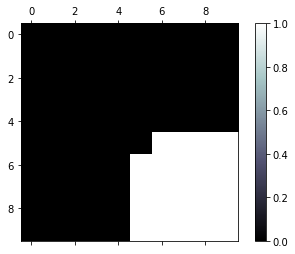

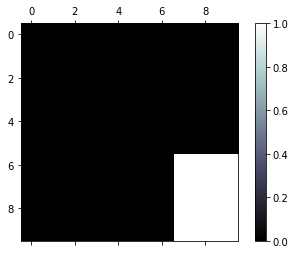

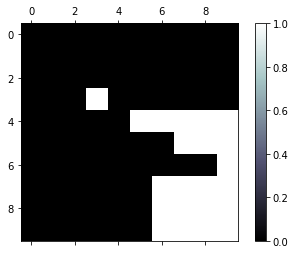

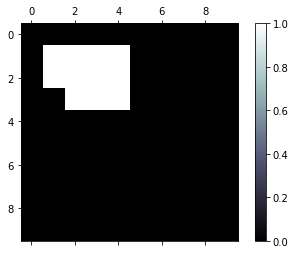

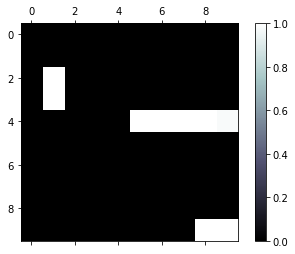

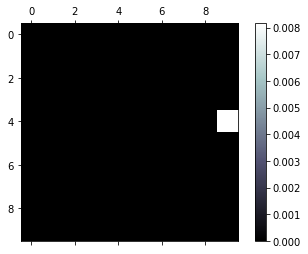

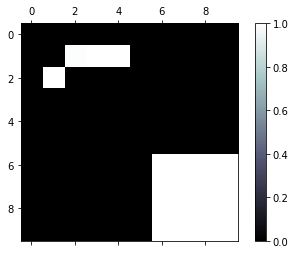

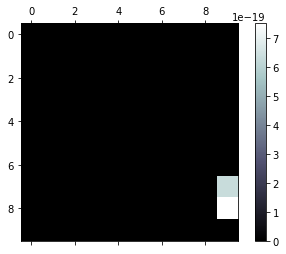

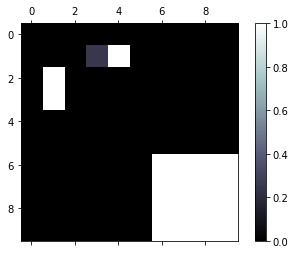

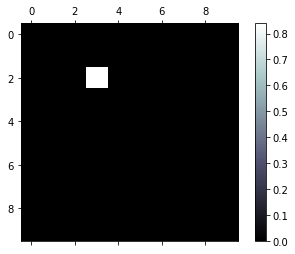

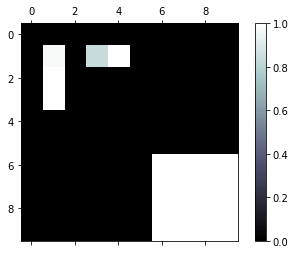

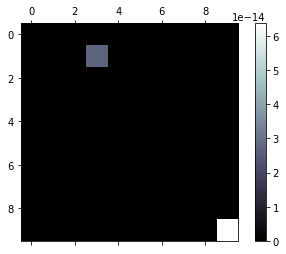

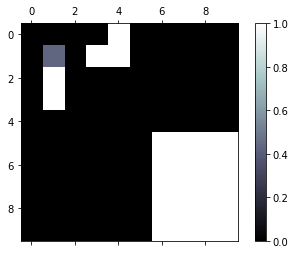

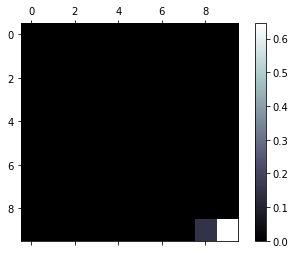

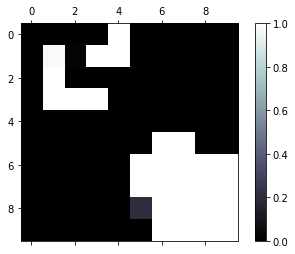

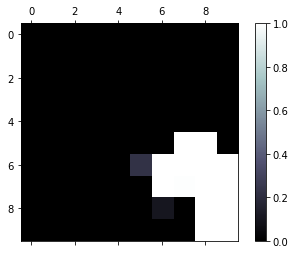

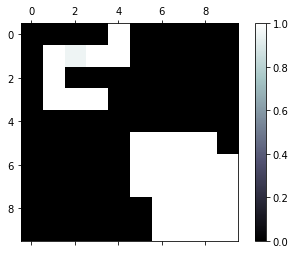

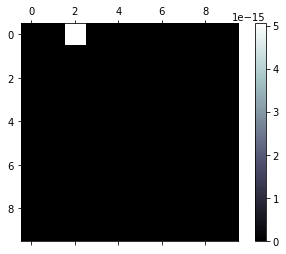

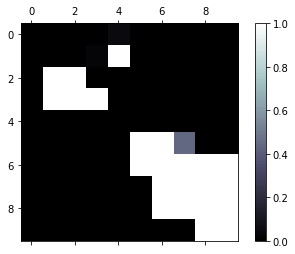

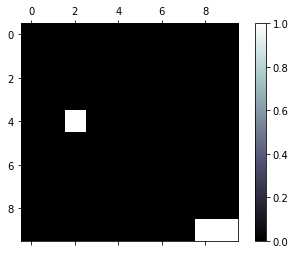

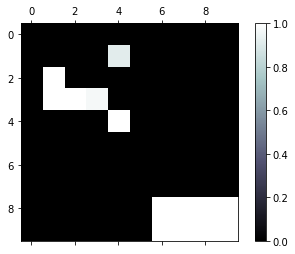

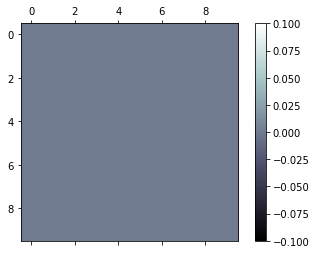

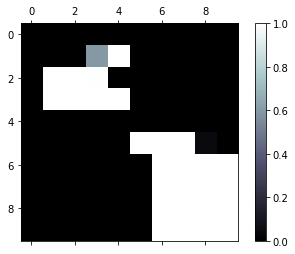

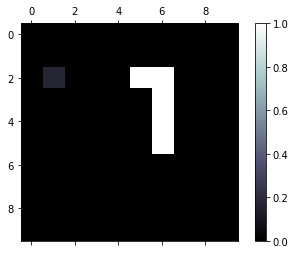

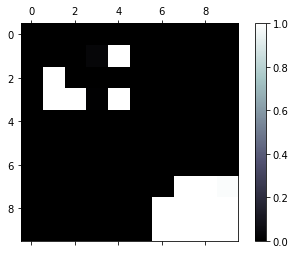

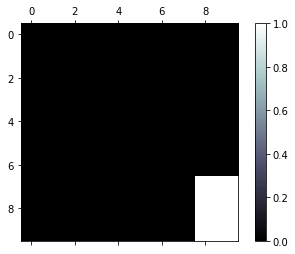

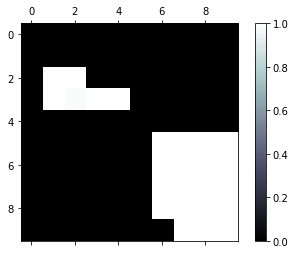

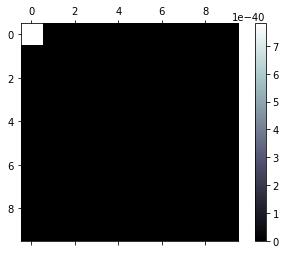

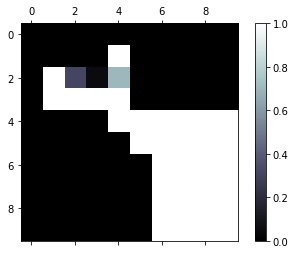

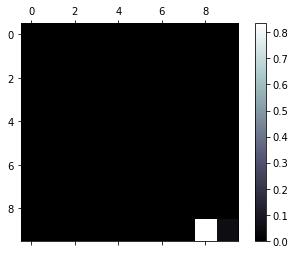

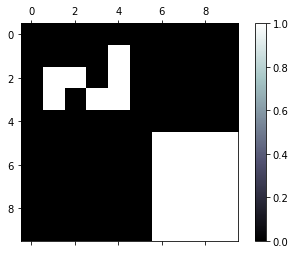

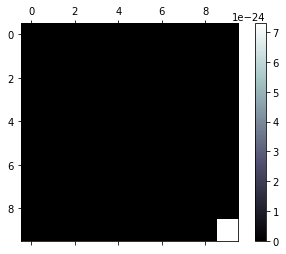

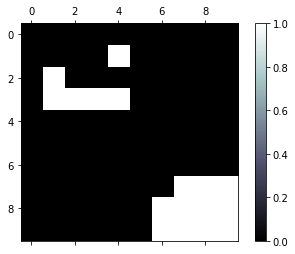

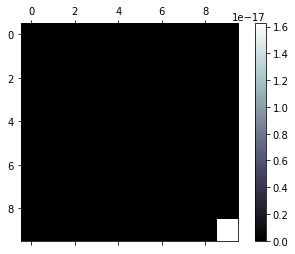

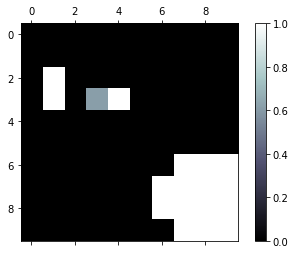

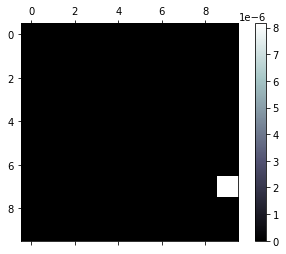

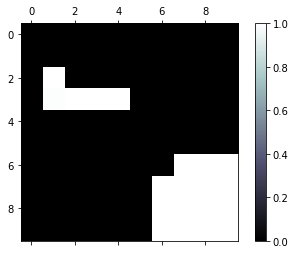

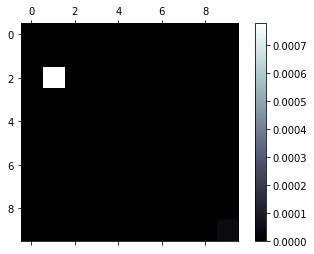

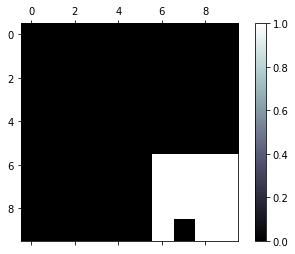

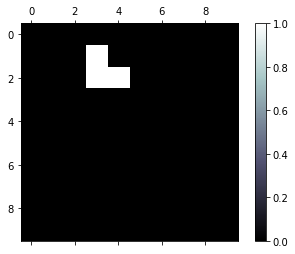

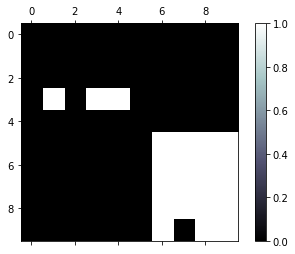

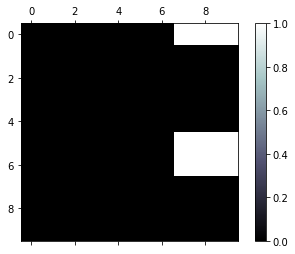

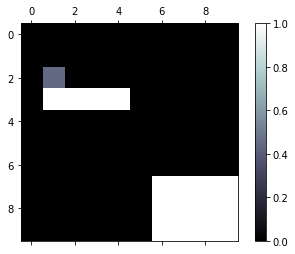

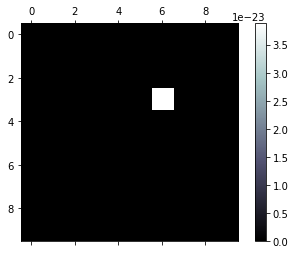

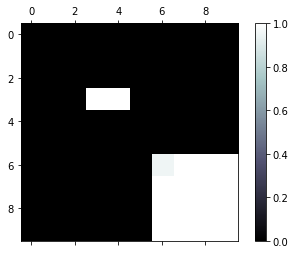

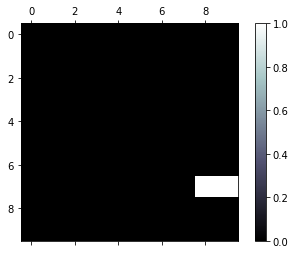

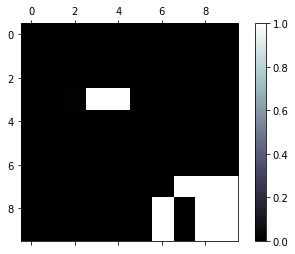

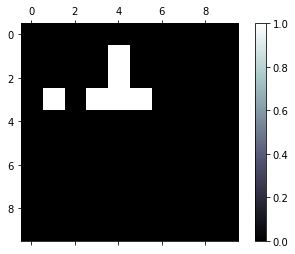

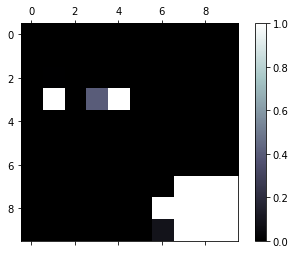

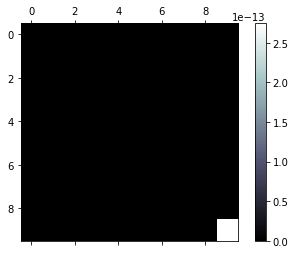

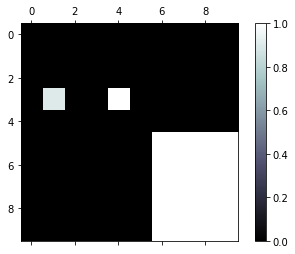

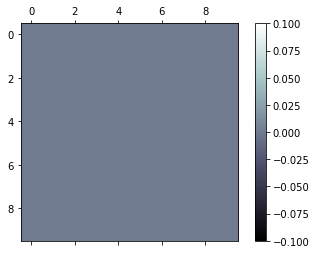

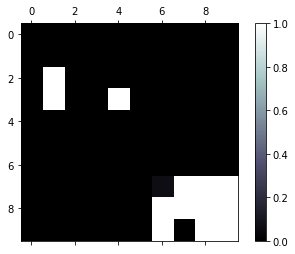

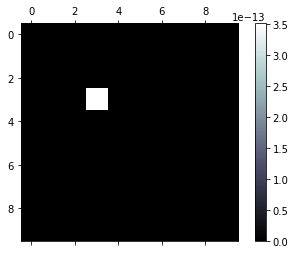

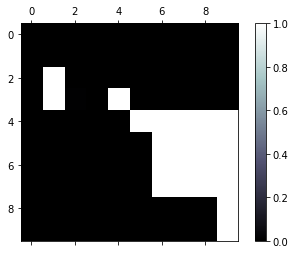

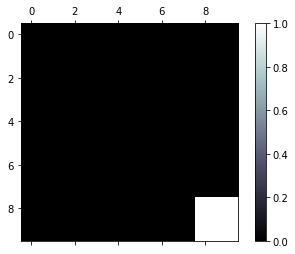

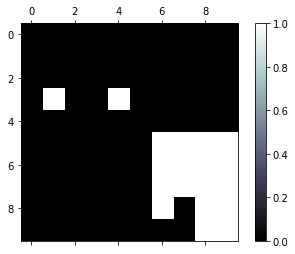

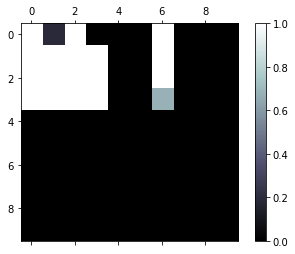

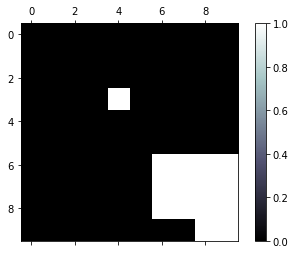

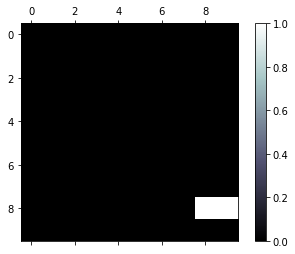

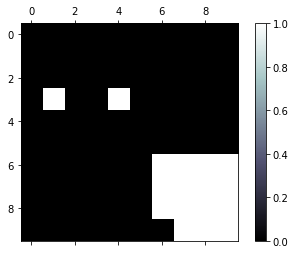

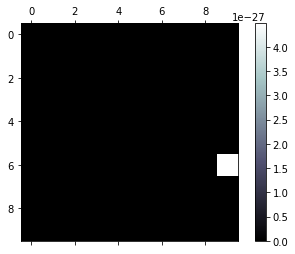

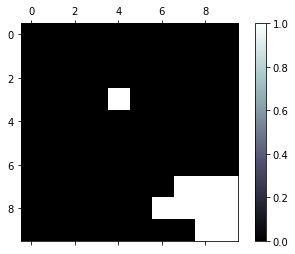

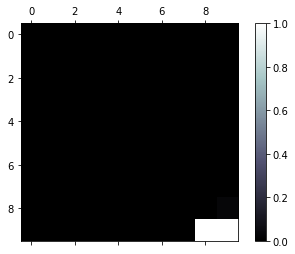

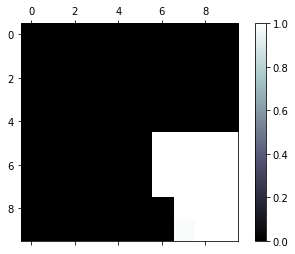

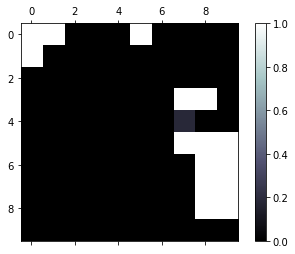

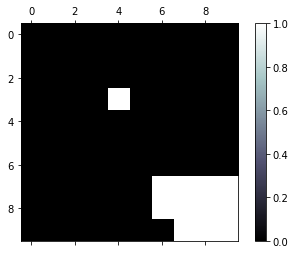

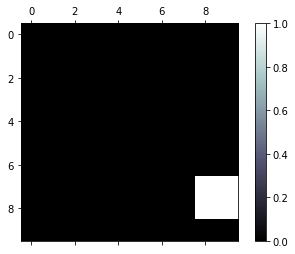

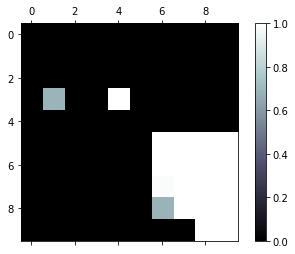

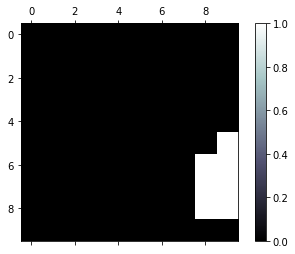

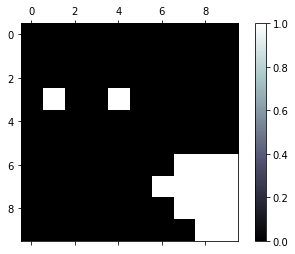

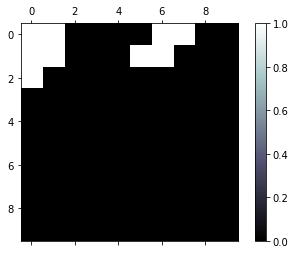

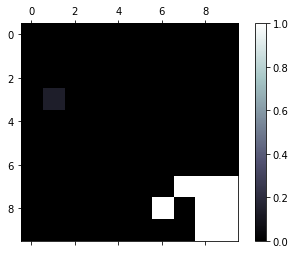

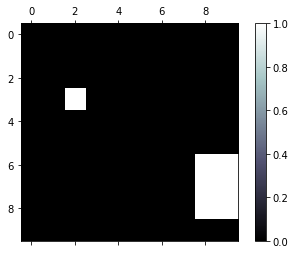

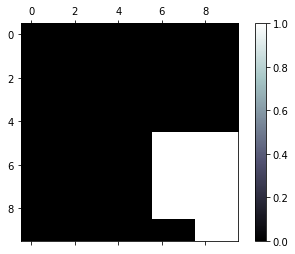

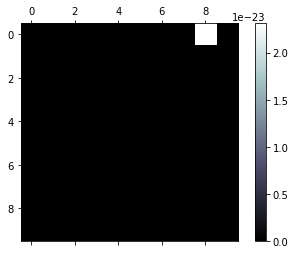

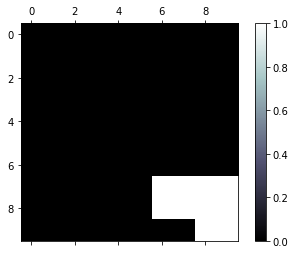

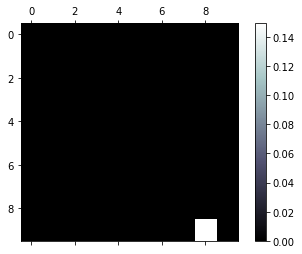

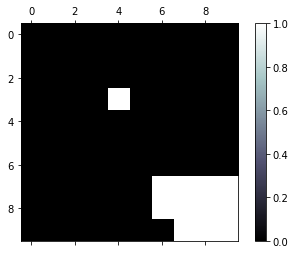

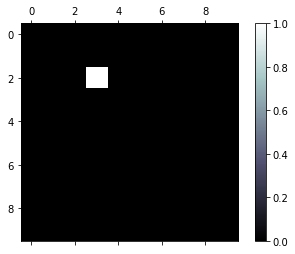

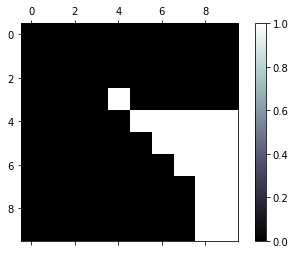

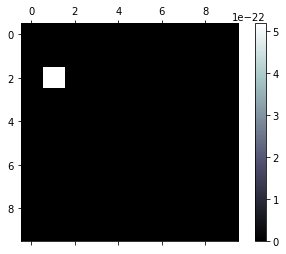

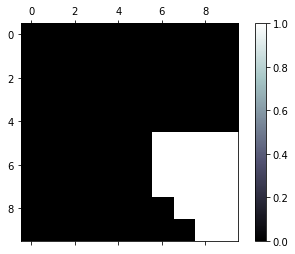

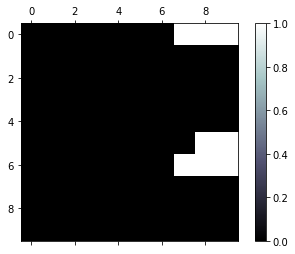

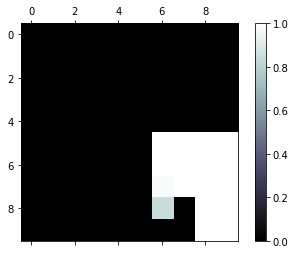

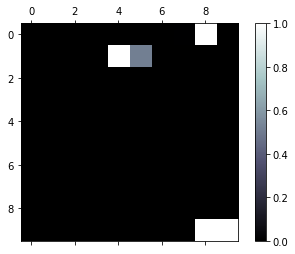

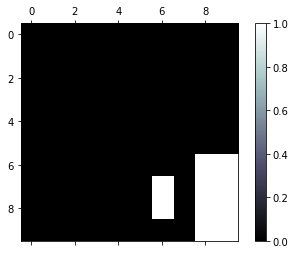

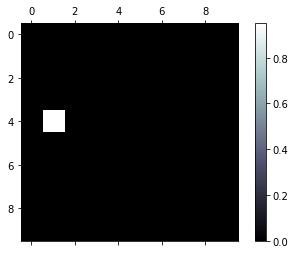

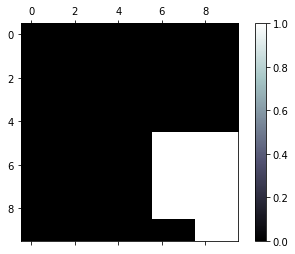

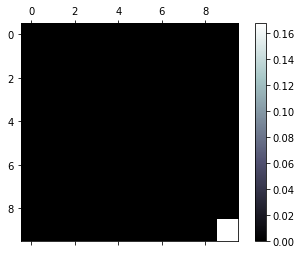

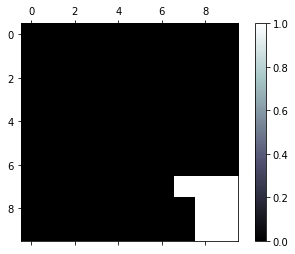

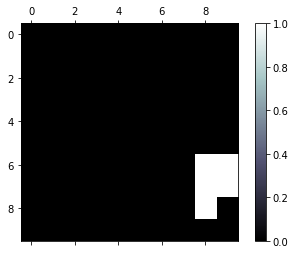

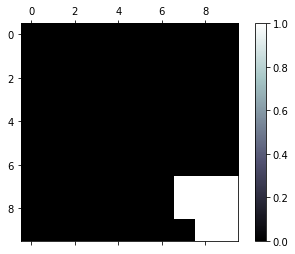

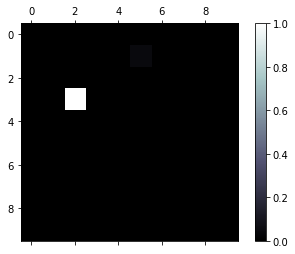

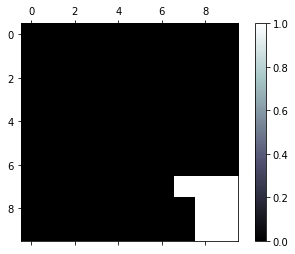

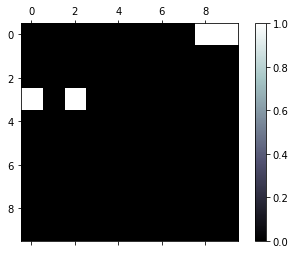

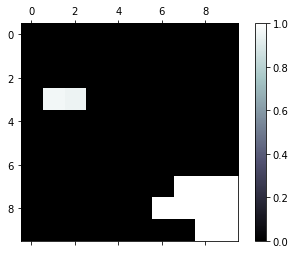

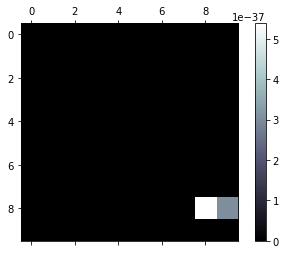

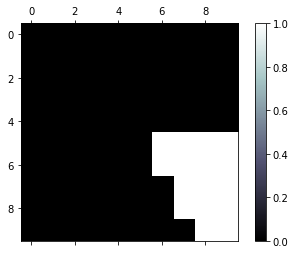

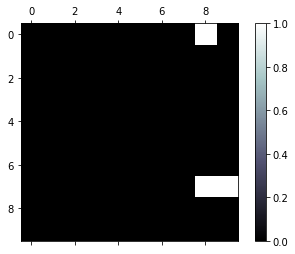

In [ ]:
%matplotlib inline
if use_cuda:
    encoder = encoder.cuda()
    decoder = decoder.cuda()

encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)

logging.info("Starting training")

run_train(n_epochs,
          batch_size,
          eval_batch_size,
          eval_every,
          train,
          val,
          encoder_embedding_map,
          decoder_embedding_map,
          encoder,
          decoder,
          encoder_optimizer,
          decoder_optimizer,
          clip_norm,
          teacher_forcing_ratio,
          use_cuda,
          )



In [ ]:
#reference : https://github.com/rawmarshmellows/pytorch-batch-luong-attention/blob/master/train_luong_attention.py

NameError: ignored